https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

In [1651]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score
from keras import backend as K
from tensorflow.keras.utils import plot_model
import random
from keras.regularizers import L2
import plotly.graph_objs as go
from sklearn import preprocessing

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [1652]:
# load final clean dataset
df = pd.read_csv('merged_clean_data.csv')

In [1653]:
# df.set_index('Date/Time', inplace = True)
print(df[df['provincename'] == 'Quebec'].index.min())
print(df[df['provincename'] == 'Quebec'].index.max())

0
74287


In [1654]:
# convert date/time to date time format
df['Date/Time'] = pd.to_datetime(df['Date/Time'])

# filter data to remove the rows that doesn't have productivity values
df = df[df['Date/Time'] <= '2021-12-31']

# set date/time as index
df.set_index('Date/Time', inplace = True)

# drop unnecessary columns
sectors_todrop = ['Manufacturing', 'Utilities', 'Educational services', 'Accommodation and food services', 'Other services except public administration',
                  'Public administration', 'Finance and insurance, real estate and rental and leasing', 'Professional scientific and technical services',
                  'Information culture and recreation']

df.drop(columns = sectors_todrop, inplace = True)

# convert 'GeoUID' to string
df['GeoUID'] = df['GeoUID'].astype('str')

# rename columns
df.rename(columns={'Agriculture forestry fishing hunting, Mining quarrying and oil and gas extraction': 'Agriculture'}, inplace=True)


In [1655]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 82505 entries, 1998-01-01 to 2017-12-01
Data columns (total 24 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   provincename                       82505 non-null  object 
 1   Longitude                          82505 non-null  float64
 2   Latitude                           82505 non-null  float64
 3   Region.Name                        82505 non-null  object 
 4   Construction                       82505 non-null  float64
 5   Transportation and warehousing     82505 non-null  float64
 6   Health care and social assistance  82505 non-null  float64
 7   Agriculture                        82505 non-null  float64
 8   Wholesale trade Retail trade       82505 non-null  float64
 9   Population                         82505 non-null  float64
 10  GeoUID                             82505 non-null  object 
 11  Station Name                       82

## (1) Univariate ##

(1.1) Combination of all 5 provinces

In [1656]:
# RESAMPLING THE DATASET TO MONTHLY #

# split data into numeric and string
num_cols = df.select_dtypes(include = ['number'])

# resample numeric data
resampled = num_cols.resample("M").mean()

In [1657]:
# define a function that will split the sequence into desired number of steps
def split_sequence(df, n_features):
    data = df.values
    X, y = [], []
    for i in range(len(data)):
        end_ix = i + n_features
        if end_ix > len(data) - 1:
            break
        seq_x, seq_y = data[i:end_ix, :], data[end_ix, 0]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

columns = ['Construction', 
            'Transportation and warehousing', 
            'Health care and social assistance', 
            'Agriculture', 
            'Wholesale trade Retail trade', 
            'Mean Max Temp (°C)', 
            'Mean Min Temp (°C)', 
            'Mean Temp (°C)', 
            'Extr Max Temp (°C)', 
            'Extr Min Temp (°C)', 
            'Total Rain (mm)', 
            'Total Snow (cm)', 
            'Total Precip (mm)', 
            'Snow Grnd Last Day (cm)', 
            'Dir of Max Gust (10s deg)', 
            'Spd of Max Gust (km/h)']

            Mean Max Temp (°C)
Date/Time                     
1998-01-31           -3.476795
1998-02-28            2.335362
1998-03-31            4.270940
1998-04-30           12.866301
1998-05-31           19.732610


<Axes: title={'center': 'Mean Max Temp (°C)'}, xlabel='Date/Time'>

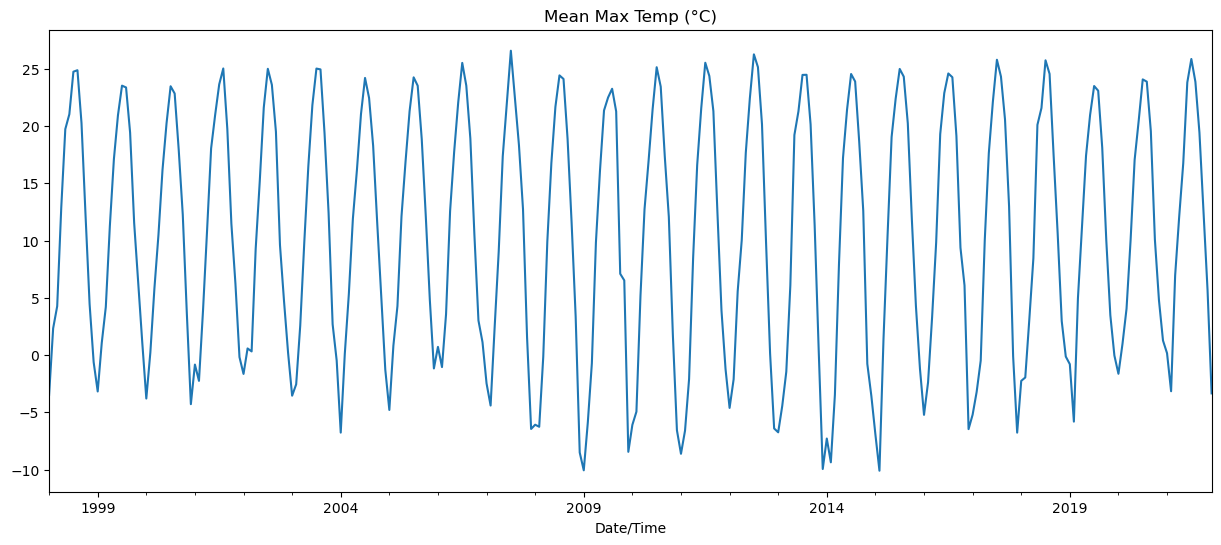

In [1658]:
lstm_data = pd.DataFrame(resampled['Mean Max Temp (°C)'])
print(lstm_data.head(5))
lstm_data['Mean Max Temp (°C)'].plot(title = 'Mean Max Temp (°C)')

In [1659]:
# split into train and test
train_end_date = '2018-12-31'

train_data = lstm_data[lstm_data.index <= train_end_date]
test_data = lstm_data[lstm_data.index > train_end_date]

print(f'Train data:')
print(train_data.index.min())
print(train_data.index.max())
print(f'Test data:')
print(test_data.index.min())
print(test_data.index.max())

# TRAIN DATA #

# number of time steps
n_steps = 7

# split into samples | will have features and target variables
X_train, y_train = split_sequence(train_data, n_steps)

# for i in range(len(X_train)):
#  print(X_train[i], y_train[i])
 
 # TEST DATA #

# split into samples | will have features and target variables
X_test, y_test = split_sequence(test_data, n_steps)

# for i in range(len(X_test)):
#  print(X_test[i], y_test[i])

Train data:
1998-01-31 00:00:00
2018-12-31 00:00:00
Test data:
2019-01-31 00:00:00
2021-12-31 00:00:00


LSTM Model Development

Mean Squared Error (MSE) from the last epoch: 4.944284915924072
R-squared from the last epoch: 0.9558866024017334


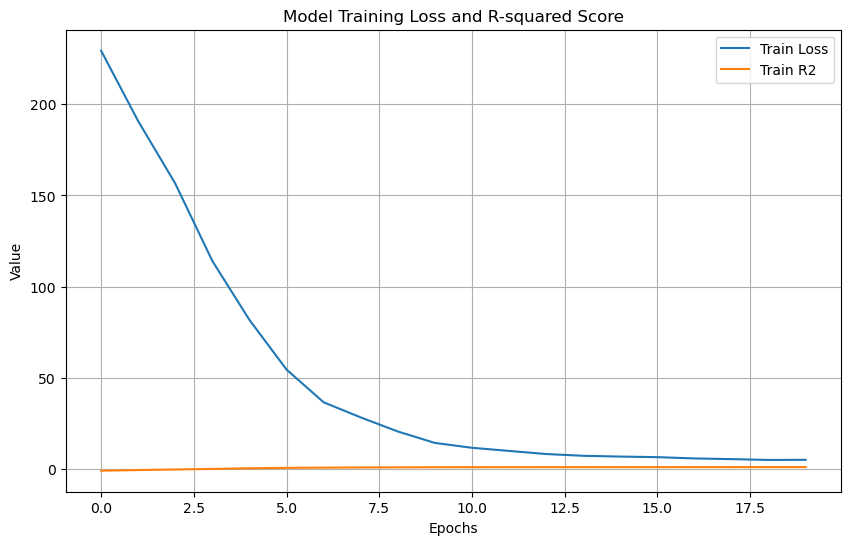

1/1 [==============================] - 0s 207ms/step - loss: 4.8831 - r_squared: 0.9450
MSE and R_squared: [4.883053302764893, 0.9450364112854004]
1/1 [==============================] - 0s 224ms/step
Predictions:
[22.960388, 18.462368, 12.228961, 4.1727657, -2.436974, -2.1461465, 0.6523914, 7.5095096, 13.005651, 16.132645]
Actual values:
[23.084314, 18.107363, 10.029046, 3.4845816, -0.034818, -1.6331472, 0.9750149, 4.0515352, 10.023047, 17.053726]


In [1660]:
n_features = 1
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], n_features)

# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))

# model = Sequential()
# model.add(LSTM(100, activation='relu', input_shape=(n_steps, n_features), kernel_regularizer=L2(0.001), return_sequences=True))
# model.add(LSTM(50, activation='relu', kernel_regularizer=L2(0.01)))
# model.add(Dense(1))

def r_squared(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# Compile the model
model.compile(optimizer='adam', 
              loss='mse',
              metrics=[r_squared])

early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

# fit model
history = model.fit(X_train, y_train, 
          epochs = 20,
          batch_size = 32,
          verbose = 0,
          callbacks=[early_stopping])

# Obtain the MSE and R-squared from the last epoch
last_epoch_mse = history.history['loss'][-1]
last_epoch_r_squared = history.history['r_squared'][-1]

# Print the MSE and R-squared
print("Mean Squared Error (MSE) from the last epoch:", last_epoch_mse)
print("R-squared from the last epoch:", last_epoch_r_squared)

# plot loss and r2 score
plt.figure(figsize=(10, 6))

# Plot train loss
plt.plot(history.history['loss'], label='Train Loss')

# Plot train R-squared score
plt.plot(history.history['r_squared'], label='Train R2')

plt.title('Model Training Loss and R-squared Score')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print("MSE and R_squared:", loss)

# make prediction on test data
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], n_features)
y_pred = model.predict(X_test)

# Print the first 5 predictions and actual values
print("Predictions:")
flattened_predictions = [pred[0] for pred in y_pred[:10]]
print(flattened_predictions)
# print(y_pred[:10].tolist())
print("Actual values:")
rounded_actual_values = [round(value, len(str(prediction).split('.')[1])) for value, prediction in zip(y_test[:10], flattened_predictions)]
print(rounded_actual_values)

# plot the actual and predicted values for test data
trace1 = go.Scatter(x=np.arange(len(y_test)), y=y_test.flatten(), mode='lines', name='Actual')
trace2 = go.Scatter(x=np.arange(len(y_pred)), y=y_pred.flatten(), mode='lines', name='Predicted')

# Create layout
layout = go.Layout(
    title='LSTM Univariate Prediction on Mean Max Temp (°C)',
    xaxis=dict(title='Time step'),
    yaxis=dict(title='Construction'),
    legend=dict(x=0, y=1.18)
)

# Create figure
fig = go.Figure(data=[trace1, trace2], layout=layout)

# Show plot
fig.show()

(1.2) Alberta

In [1661]:
resampled_AB = df[df['provincename'] == 'Alberta']

# RESAMPLING THE DATASET TO MONTHLY #

# split data into numeric and string
num_cols = resampled_AB.select_dtypes(include = ['number'])

# resample numeric data
resampled = num_cols.resample("M").mean()

In [1662]:
# define a function that will split the sequence into desired number of steps
def split_sequence(df, n_features):
    data = df.values
    X, y = [], []
    for i in range(len(data)):
        end_ix = i + n_features
        if end_ix > len(data) - 1:
            break
        seq_x, seq_y = data[i:end_ix, :], data[end_ix, 0]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

columns = ['Construction', 
            'Transportation and warehousing', 
            'Health care and social assistance', 
            'Agriculture', 
            'Wholesale trade Retail trade', 
            'Mean Max Temp (°C)', 
            'Mean Min Temp (°C)', 
            'Mean Temp (°C)', 
            'Extr Max Temp (°C)', 
            'Extr Min Temp (°C)', 
            'Total Rain (mm)', 
            'Total Snow (cm)', 
            'Total Precip (mm)', 
            'Snow Grnd Last Day (cm)', 
            'Dir of Max Gust (10s deg)', 
            'Spd of Max Gust (km/h)']

            Mean Max Temp (°C)
Date/Time                     
1998-01-31           -9.174123
1998-02-28            1.726643
1998-03-31            2.130065
1998-04-30           13.155375
1998-05-31           20.054474


<Axes: title={'center': 'Mean Max Temp (°C)'}, xlabel='Date/Time'>

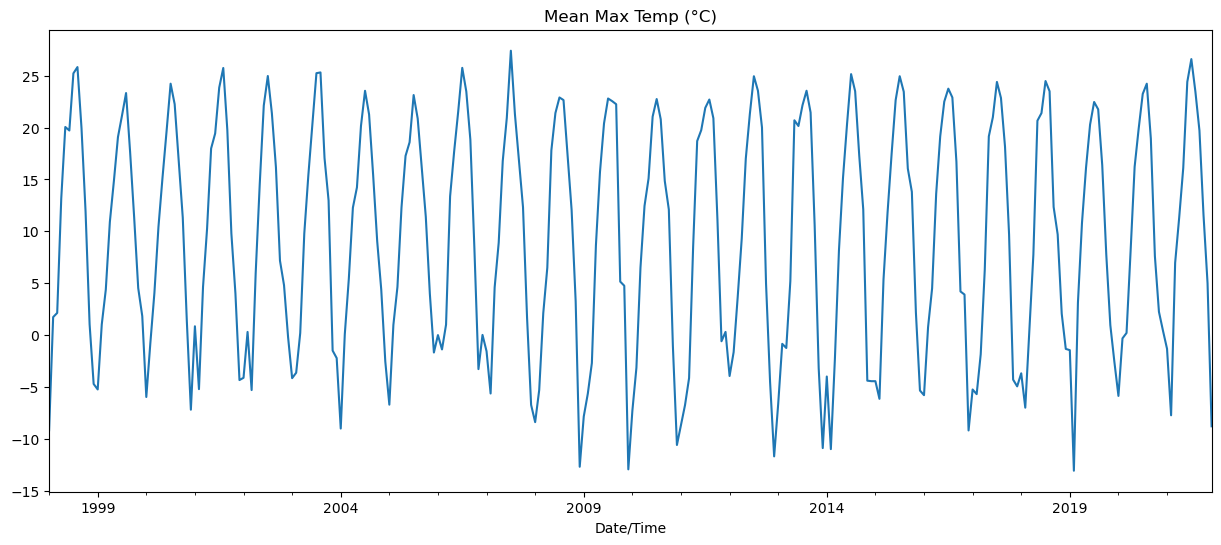

In [1663]:
lstm_data = pd.DataFrame(resampled['Mean Max Temp (°C)'])
print(lstm_data.head(5))
lstm_data['Mean Max Temp (°C)'].plot(title = 'Mean Max Temp (°C)')

In [1664]:
# split into train and test
train_end_date = '2018-12-31'

train_data = lstm_data[lstm_data.index <= train_end_date]
test_data = lstm_data[lstm_data.index > train_end_date]

print(f'Train data:')
print(train_data.index.min())
print(train_data.index.max())
print(f'Test data:')
print(test_data.index.min())
print(test_data.index.max())

# TRAIN DATA #

# number of time steps
n_steps = 7

# split into samples | will have features and target variables
X_train, y_train = split_sequence(train_data, n_steps)

# for i in range(len(X_train)):
#  print(X_train[i], y_train[i])
 
 # TEST DATA #

# split into samples | will have features and target variables
X_test, y_test = split_sequence(test_data, n_steps)

# for i in range(len(X_test)):
#  print(X_test[i], y_test[i])

Train data:
1998-01-31 00:00:00
2018-12-31 00:00:00
Test data:
2019-01-31 00:00:00
2021-12-31 00:00:00


LSTM Model Development

Mean Squared Error (MSE) from the last epoch: 9.887964248657227
R-squared from the last epoch: 0.9120568037033081


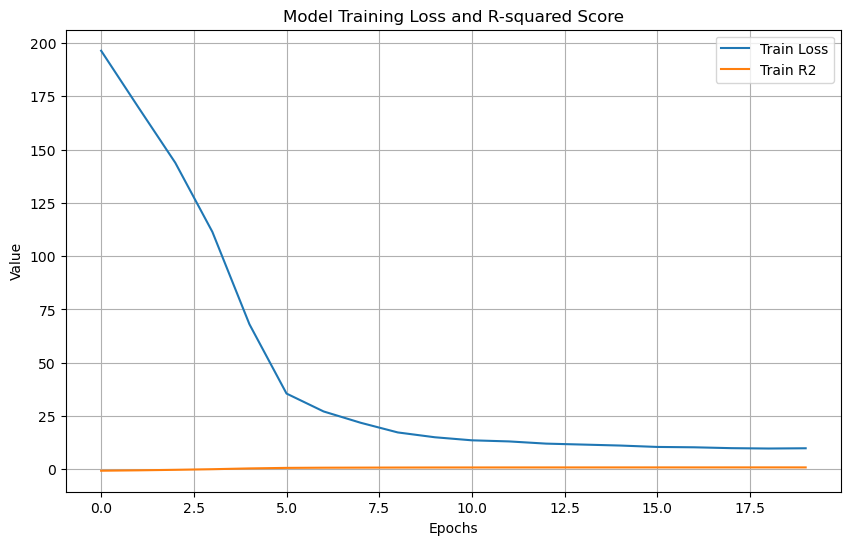

1/1 [==============================] - 0s 276ms/step - loss: 11.8685 - r_squared: 0.8946
MSE and R_squared: [11.868473052978516, 0.8946093916893005]
1/1 [==============================] - 0s 249ms/step
Predictions:
[20.168936, 14.015304, 8.344124, -0.5711663, -5.3610687, -4.074276, -2.5069873, 2.467887, 8.420435, 12.636818]
Actual values:
[21.754725, 16.376635, 7.74603, 0.9472928, -2.592007, -5.870697, -0.3227814, 0.198511, 8.063654, 16.223059]


In [1665]:
n_features = 1
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], n_features)

# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))

# model = Sequential()
# model.add(LSTM(100, activation='relu', input_shape=(n_steps, n_features), kernel_regularizer=L2(0.001), return_sequences=True))
# model.add(LSTM(50, activation='relu', kernel_regularizer=L2(0.01)))
# model.add(Dense(1))

def r_squared(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# Compile the model
model.compile(optimizer='adam', 
              loss='mse',
              metrics=[r_squared])

early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

# fit model
history = model.fit(X_train, y_train, 
          epochs = 20,
          batch_size = 32,
          verbose = 0,
          callbacks=[early_stopping])

# Obtain the MSE and R-squared from the last epoch
last_epoch_mse = history.history['loss'][-1]
last_epoch_r_squared = history.history['r_squared'][-1]

# Print the MSE and R-squared
print("Mean Squared Error (MSE) from the last epoch:", last_epoch_mse)
print("R-squared from the last epoch:", last_epoch_r_squared)

# plot loss and r2 score
plt.figure(figsize=(10, 6))

# Plot train loss
plt.plot(history.history['loss'], label='Train Loss')

# Plot train R-squared score
plt.plot(history.history['r_squared'], label='Train R2')

plt.title('Model Training Loss and R-squared Score')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print("MSE and R_squared:", loss)

# make prediction on test data
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], n_features)
y_pred = model.predict(X_test)

# Print the first 5 predictions and actual values
print("Predictions:")
flattened_predictions = [pred[0] for pred in y_pred[:10]]
print(flattened_predictions)
# print(y_pred[:10].tolist())
print("Actual values:")
rounded_actual_values = [round(value, len(str(prediction).split('.')[1])) for value, prediction in zip(y_test[:10], flattened_predictions)]
print(rounded_actual_values)

# plot the actual and predicted values for test data
trace1 = go.Scatter(x=np.arange(len(y_test)), y=y_test.flatten(), mode='lines', name='Actual')
trace2 = go.Scatter(x=np.arange(len(y_pred)), y=y_pred.flatten(), mode='lines', name='Predicted')

# Create layout
layout = go.Layout(
    title='Alberta: LSTM Univariate Prediction on Mean Max Temp (°C)',
    xaxis=dict(title='Time step'),
    yaxis=dict(title='Construction'),
    legend=dict(x=0, y=1.18)
)

# Create figure
fig = go.Figure(data=[trace1, trace2], layout=layout)

# Show plot
fig.show()

(1.3) Bristish Columbia

In [1666]:
resampled_BC = df[df['provincename'] == 'British Columbia']

# RESAMPLING THE DATASET TO MONTHLY #

# split data into numeric and string
num_cols = resampled_BC.select_dtypes(include = ['number'])

# resample numeric data
resampled = num_cols.resample("M").mean()

In [1667]:
# define a function that will split the sequence into desired number of steps
def split_sequence(df, n_features):
    data = df.values
    X, y = [], []
    for i in range(len(data)):
        end_ix = i + n_features
        if end_ix > len(data) - 1:
            break
        seq_x, seq_y = data[i:end_ix, :], data[end_ix, 0]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


columns = ['Construction', 
            'Transportation and warehousing', 
            'Health care and social assistance', 
            'Agriculture', 
            'Wholesale trade Retail trade', 
            'Mean Max Temp (°C)', 
            'Mean Min Temp (°C)', 
            'Mean Temp (°C)', 
            'Extr Max Temp (°C)', 
            'Extr Min Temp (°C)', 
            'Total Rain (mm)', 
            'Total Snow (cm)', 
            'Total Precip (mm)', 
            'Snow Grnd Last Day (cm)', 
            'Dir of Max Gust (10s deg)', 
            'Spd of Max Gust (km/h)']

            Mean Max Temp (°C)
Date/Time                     
1998-01-31            1.668112
1998-02-28            5.952033
1998-03-31            8.189304
1998-04-30           13.038331
1998-05-31           18.087071


<Axes: title={'center': 'Mean Max Temp (°C)'}, xlabel='Date/Time'>

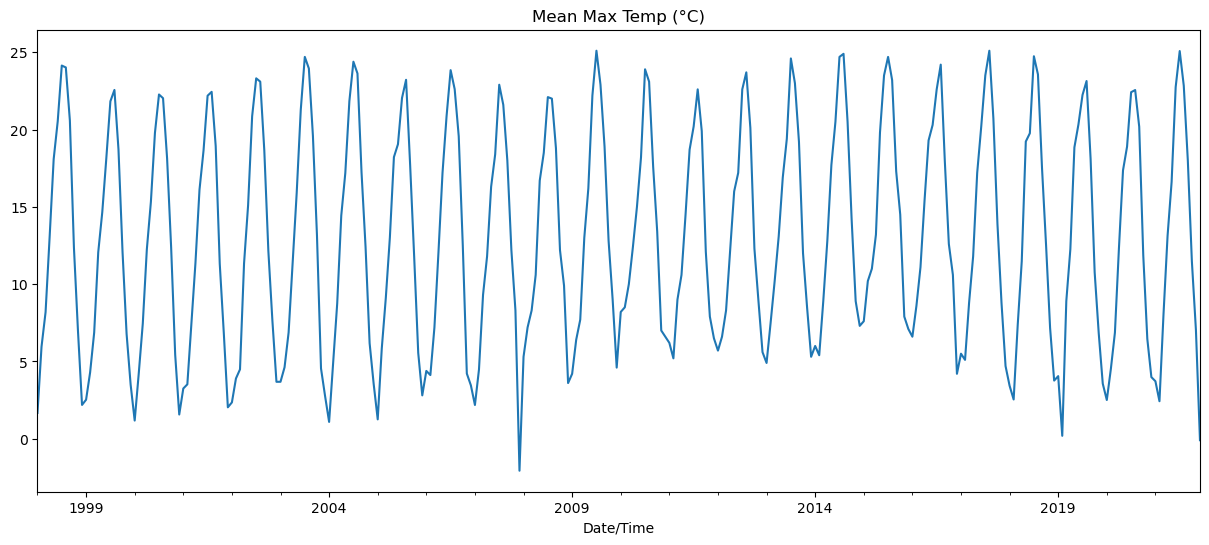

In [1668]:
lstm_data = pd.DataFrame(resampled['Mean Max Temp (°C)'])
print(lstm_data.head(5))
lstm_data['Mean Max Temp (°C)'].plot(title = 'Mean Max Temp (°C)')

In [1669]:
# split into train and test
train_end_date = '2018-12-31'

train_data = lstm_data[lstm_data.index <= train_end_date]
test_data = lstm_data[lstm_data.index > train_end_date]

print(f'Train data:')
print(train_data.index.min())
print(train_data.index.max())
print(f'Test data:')
print(test_data.index.min())
print(test_data.index.max())

# split into train and test
train_end_date = '2018-12-31'

train_data = lstm_data[lstm_data.index <= train_end_date]
test_data = lstm_data[lstm_data.index > train_end_date]

print(f'Train data:')
print(train_data.index.min())
print(train_data.index.max())
print(f'Test data:')
print(test_data.index.min())
print(test_data.index.max())

Train data:
1998-01-31 00:00:00
2018-12-31 00:00:00
Test data:
2019-01-31 00:00:00
2021-12-31 00:00:00
Train data:
1998-01-31 00:00:00
2018-12-31 00:00:00
Test data:
2019-01-31 00:00:00
2021-12-31 00:00:00


In [1670]:
# TRAIN DATA #

# number of time steps
n_steps = 7

# split into samples | will have features and target variables
X_train, y_train = split_sequence(train_data, n_steps)

# for i in range(len(X_train)):
#  print(X_train[i], y_train[i])
 
 # TEST DATA #

# split into samples | will have features and target variables
X_test, y_test = split_sequence(test_data, n_steps)

# for i in range(len(X_test)):
#  print(X_test[i], y_test[i])

Mean Squared Error (MSE) from the last epoch: 2.476923942565918
R-squared from the last epoch: 0.9481590390205383


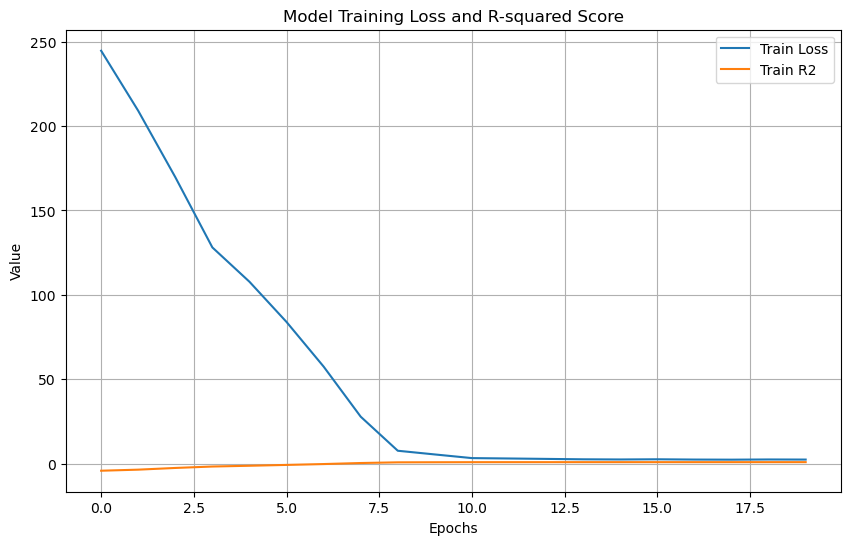

1/1 [==============================] - 0s 208ms/step - loss: 2.6594 - r_squared: 0.9544
MSE and R_squared: [2.659397840499878, 0.9544475674629211]
1/1 [==============================] - 0s 148ms/step
Predictions:
[21.329365, 19.07568, 12.424226, 6.445161, 4.7268085, 4.413263, 5.385495, 8.630001, 12.663394, 17.084436]
Actual values:
[23.138081, 18.09534, 10.769611, 6.84044, 3.5623485, 2.502857, 4.514062, 6.858667, 12.355003, 17.363426]


In [1671]:
n_features = 1
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], n_features)

# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))

# model = Sequential()
# model.add(LSTM(100, activation='relu', input_shape=(n_steps, n_features), kernel_regularizer=L2(0.001), return_sequences=True))
# model.add(LSTM(50, activation='relu', kernel_regularizer=L2(0.01)))
# model.add(Dense(1))

def r_squared(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# Compile the model
model.compile(optimizer='adam', 
              loss='mse',
              metrics=[r_squared])

early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

# fit model
history = model.fit(X_train, y_train, 
          epochs = 20,
          batch_size = 32,
          verbose = 0,
          callbacks=[early_stopping])

# Obtain the MSE and R-squared from the last epoch
last_epoch_mse = history.history['loss'][-1]
last_epoch_r_squared = history.history['r_squared'][-1]

# Print the MSE and R-squared
print("Mean Squared Error (MSE) from the last epoch:", last_epoch_mse)
print("R-squared from the last epoch:", last_epoch_r_squared)

# plot loss and r2 score
plt.figure(figsize=(10, 6))

# Plot train loss
plt.plot(history.history['loss'], label='Train Loss')

# Plot train R-squared score
plt.plot(history.history['r_squared'], label='Train R2')

plt.title('Model Training Loss and R-squared Score')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print("MSE and R_squared:", loss)

# make prediction on test data
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], n_features)
y_pred = model.predict(X_test)

# Print the first 5 predictions and actual values
print("Predictions:")
flattened_predictions = [pred[0] for pred in y_pred[:10]]
print(flattened_predictions)
# print(y_pred[:10].tolist())
print("Actual values:")
rounded_actual_values = [round(value, len(str(prediction).split('.')[1])) for value, prediction in zip(y_test[:10], flattened_predictions)]
print(rounded_actual_values)

# plot the actual and predicted values for test data
trace1 = go.Scatter(x=np.arange(len(y_test)), y=y_test.flatten(), mode='lines', name='Actual')
trace2 = go.Scatter(x=np.arange(len(y_pred)), y=y_pred.flatten(), mode='lines', name='Predicted')

# Create layout
layout = go.Layout(
    title='British Columbia: LSTM Univariate Prediction on Mean Max Temp (°C)',
    xaxis=dict(title='Time step'),
    yaxis=dict(title='Construction'),
    legend=dict(x=0, y=1.18)
)

# Create figure
fig = go.Figure(data=[trace1, trace2], layout=layout)

# Show plot
fig.show()

(1.4) Ontario

In [1672]:
resampled_ON = df[df['provincename'] == 'Ontario']

# RESAMPLING THE DATASET TO MONTHLY #

# split data into numeric and string
num_cols = resampled_ON.select_dtypes(include = ['number'])

# resample numeric data
resampled = num_cols.resample("M").mean()

In [1673]:
# define a function that will split the sequence into desired number of steps
def split_sequence(df, n_features):
    data = df.values
    X, y = [], []
    for i in range(len(data)):
        end_ix = i + n_features
        if end_ix > len(data) - 1:
            break
        seq_x, seq_y = data[i:end_ix, :], data[end_ix, 0]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

columns = ['Construction', 
            'Transportation and warehousing', 
            'Health care and social assistance', 
            'Agriculture', 
            'Wholesale trade Retail trade', 
            'Mean Max Temp (°C)', 
            'Mean Min Temp (°C)', 
            'Mean Temp (°C)', 
            'Extr Max Temp (°C)', 
            'Extr Min Temp (°C)', 
            'Total Rain (mm)', 
            'Total Snow (cm)', 
            'Total Precip (mm)', 
            'Snow Grnd Last Day (cm)', 
            'Dir of Max Gust (10s deg)', 
            'Spd of Max Gust (km/h)']

            Mean Max Temp (°C)
Date/Time                     
1998-01-31           -1.335346
1998-02-28            2.038014
1998-03-31            4.565397
1998-04-30           13.340110
1998-05-31           21.705825


<Axes: title={'center': 'Mean Max Temp (°C)'}, xlabel='Date/Time'>

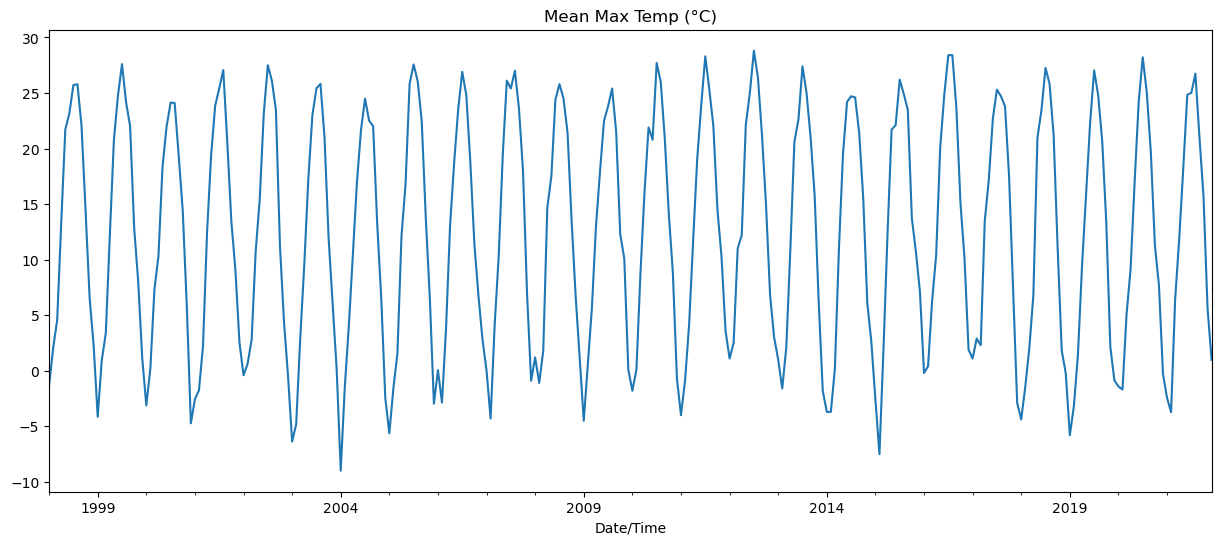

In [1674]:
lstm_data = pd.DataFrame(resampled['Mean Max Temp (°C)'])
print(lstm_data.head(5))
lstm_data['Mean Max Temp (°C)'].plot(title = 'Mean Max Temp (°C)')

In [1675]:
# split into train and test
train_end_date = '2018-12-31'

train_data = lstm_data[lstm_data.index <= train_end_date]
test_data = lstm_data[lstm_data.index > train_end_date]

print(f'Train data:')
print(train_data.index.min())
print(train_data.index.max())
print(f'Test data:')
print(test_data.index.min())
print(test_data.index.max())

# TRAIN DATA #

# number of time steps
n_steps = 7

# split into samples | will have features and target variables
X_train, y_train = split_sequence(train_data, n_steps)

# for i in range(len(X_train)):
#  print(X_train[i], y_train[i])
 
 # TEST DATA #

# split into samples | will have features and target variables
X_test, y_test = split_sequence(test_data, n_steps)

# for i in range(len(X_test)):
#  print(X_test[i], y_test[i])

Train data:
1998-01-31 00:00:00
2018-12-31 00:00:00
Test data:
2019-01-31 00:00:00
2021-12-31 00:00:00


LSTM Model Development

Mean Squared Error (MSE) from the last epoch: 5.044878959655762
R-squared from the last epoch: 0.9533793926239014


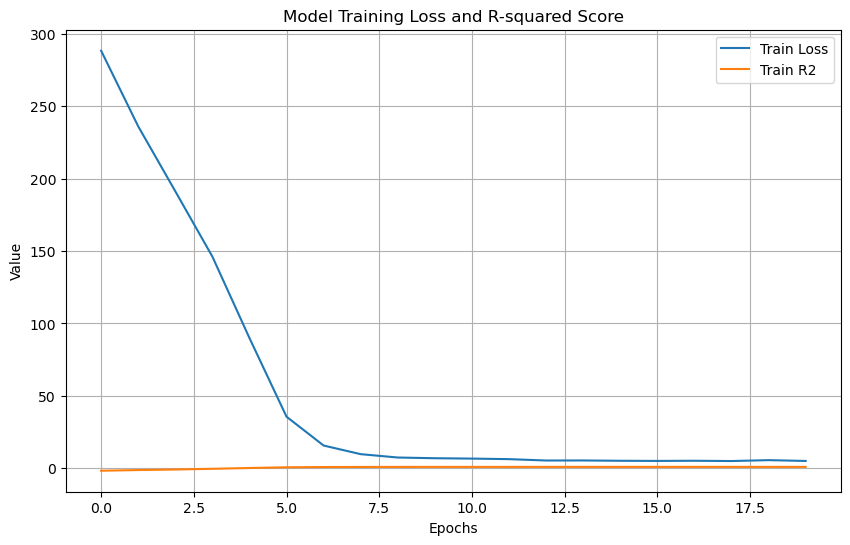

1/1 [==============================] - 0s 264ms/step - loss: 9.6762 - r_squared: 0.9093
MSE and R_squared: [9.676178932189941, 0.9092914462089539]
1/1 [==============================] - 0s 199ms/step
Predictions:
[27.239628, 21.936754, 14.955943, 6.878144, -1.5824584, -2.8364828, -0.5700957, 4.142305, 13.402418, 16.806719]
Actual values:
[24.797382, 20.636145, 13.33077, 2.147879, -0.8703891, -1.4104612, -1.6903123, 5.038827, 9.163746, 16.984662]


In [1676]:
n_features = 1
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], n_features)

# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))

# model = Sequential()
# model.add(LSTM(100, activation='relu', input_shape=(n_steps, n_features), kernel_regularizer=L2(0.001), return_sequences=True))
# model.add(LSTM(50, activation='relu', kernel_regularizer=L2(0.01)))
# model.add(Dense(1))

def r_squared(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# Compile the model
model.compile(optimizer='adam', 
              loss='mse',
              metrics=[r_squared])

early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

# fit model
history = model.fit(X_train, y_train, 
          epochs = 20,
          batch_size = 32,
          verbose = 0,
          callbacks=[early_stopping])

# Obtain the MSE and R-squared from the last epoch
last_epoch_mse = history.history['loss'][-1]
last_epoch_r_squared = history.history['r_squared'][-1]

# Print the MSE and R-squared
print("Mean Squared Error (MSE) from the last epoch:", last_epoch_mse)
print("R-squared from the last epoch:", last_epoch_r_squared)

# plot loss and r2 score
plt.figure(figsize=(10, 6))

# Plot train loss
plt.plot(history.history['loss'], label='Train Loss')

# Plot train R-squared score
plt.plot(history.history['r_squared'], label='Train R2')

plt.title('Model Training Loss and R-squared Score')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print("MSE and R_squared:", loss)

# make prediction on test data
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], n_features)
y_pred = model.predict(X_test)

# Print the first 5 predictions and actual values
print("Predictions:")
flattened_predictions = [pred[0] for pred in y_pred[:10]]
print(flattened_predictions)
# print(y_pred[:10].tolist())
print("Actual values:")
rounded_actual_values = [round(value, len(str(prediction).split('.')[1])) for value, prediction in zip(y_test[:10], flattened_predictions)]
print(rounded_actual_values)

# plot the actual and predicted values for test data
trace1 = go.Scatter(x=np.arange(len(y_test)), y=y_test.flatten(), mode='lines', name='Actual')
trace2 = go.Scatter(x=np.arange(len(y_pred)), y=y_pred.flatten(), mode='lines', name='Predicted')

# Create layout
layout = go.Layout(
    title='Ontario: LSTM Univariate Prediction on Mean Max Temp (°C)',
    xaxis=dict(title='Time step'),
    yaxis=dict(title='Construction'),
    legend=dict(x=0, y=1.18)
)

# Create figure
fig = go.Figure(data=[trace1, trace2], layout=layout)

# Show plot
fig.show()

(1.5) Quebec

In [1677]:
resampled_QC = df[df['provincename'] == 'Quebec']

# RESAMPLING THE DATASET TO MONTHLY #

# split data into numeric and string
num_cols = resampled_QC.select_dtypes(include = ['number'])

# resample numeric data
resampled = num_cols.resample("M").mean()

In [1678]:
# define a function that will split the sequence into desired number of steps
def split_sequence(df, n_features):
    data = df.values
    X, y = [], []
    for i in range(len(data)):
        end_ix = i + n_features
        if end_ix > len(data) - 1:
            break
        seq_x, seq_y = data[i:end_ix, :], data[end_ix, 0]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

columns = ['Construction', 
            'Transportation and warehousing', 
            'Health care and social assistance', 
            'Agriculture', 
            'Wholesale trade Retail trade', 
            'Mean Max Temp (°C)', 
            'Mean Min Temp (°C)', 
            'Mean Temp (°C)', 
            'Extr Max Temp (°C)', 
            'Extr Min Temp (°C)', 
            'Total Rain (mm)', 
            'Total Snow (cm)', 
            'Total Precip (mm)', 
            'Snow Grnd Last Day (cm)', 
            'Dir of Max Gust (10s deg)', 
            'Spd of Max Gust (km/h)']

            Mean Max Temp (°C)
Date/Time                     
1998-01-31           -4.552563
1998-02-28           -0.896600
1998-03-31            2.044358
1998-04-30           11.654923
1998-05-31           20.997578


<Axes: title={'center': 'Mean Max Temp (°C)'}, xlabel='Date/Time'>

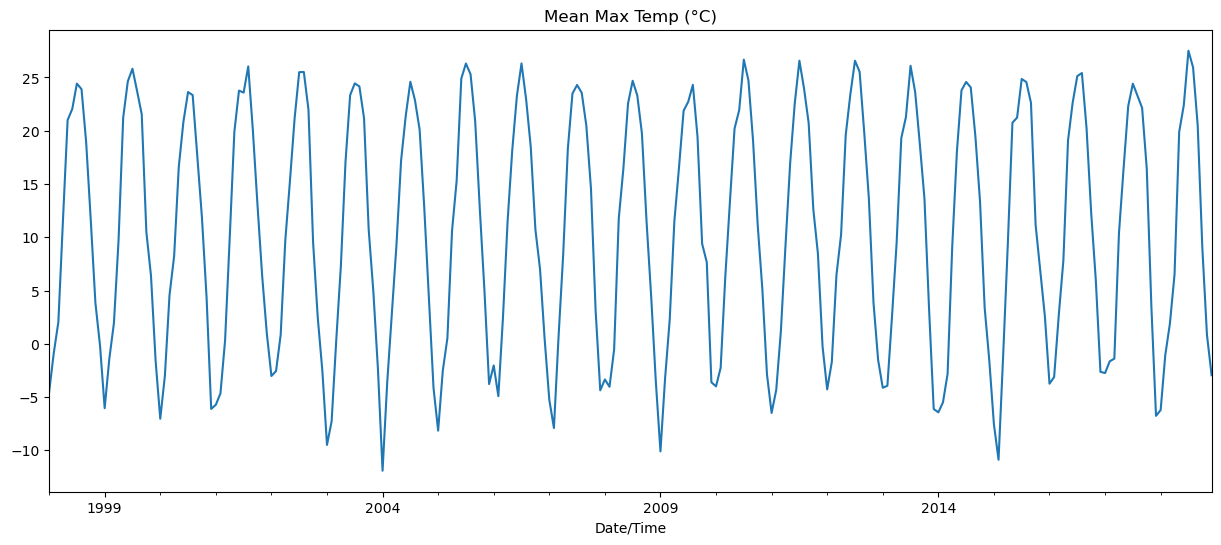

In [1679]:
lstm_data = pd.DataFrame(resampled['Mean Max Temp (°C)'])
print(lstm_data.head(5))
lstm_data['Mean Max Temp (°C)'].plot(title = 'Mean Max Temp (°C)')

In [1680]:
# Initialize an empty dictionary to store DataFrames for each column
resampled_dataframes = {}

# Iterate over each column name
for column in columns:
    # Get the data for the current column
    column_data = resampled[column]
    
    # Convert to DataFrame and store in the dictionary
    column_data_df = pd.DataFrame(column_data)
    resampled_dataframes[column] = column_data_df
    
    # Display the first 14 rows
    print(f"Data for column '{column}':")
    print(column_data_df.head(3))

Data for column 'Construction':
            Construction
Date/Time               
1998-01-31     44.009793
1998-02-28     47.135313
1998-03-31     48.664697
Data for column 'Transportation and warehousing':
            Transportation and warehousing
Date/Time                                 
1998-01-31                       26.979831
1998-02-28                       28.244141
1998-03-31                       29.007407
Data for column 'Health care and social assistance':
            Health care and social assistance
Date/Time                                    
1998-01-31                          76.390411
1998-02-28                          78.896252
1998-03-31                          79.649614
Data for column 'Agriculture':
            Agriculture
Date/Time              
1998-01-31    26.874227
1998-02-28    26.326112
1998-03-31    26.940388
Data for column 'Wholesale trade Retail trade':
            Wholesale trade Retail trade
Date/Time                               
1998-01-31    

In [1681]:
# define a function that will split the sequence into desired number of steps
def split_sequence(df, n_features):
    data = df.values
    X, y = [], []
    for i in range(len(data)):
        end_ix = i + n_features
        if end_ix > len(data) - 1:
            break
        seq_x, seq_y = data[i:end_ix, :], data[end_ix, 0]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

columns = ['Construction', 
            'Transportation and warehousing', 
            'Health care and social assistance', 
            'Agriculture', 
            'Wholesale trade Retail trade', 
            'Mean Max Temp (°C)', 
            'Mean Min Temp (°C)', 
            'Mean Temp (°C)', 
            'Extr Max Temp (°C)', 
            'Extr Min Temp (°C)', 
            'Total Rain (mm)', 
            'Total Snow (cm)', 
            'Total Precip (mm)', 
            'Snow Grnd Last Day (cm)', 
            'Dir of Max Gust (10s deg)', 
            'Spd of Max Gust (km/h)']

In [1682]:
# split into train and test
train_end_date = '2018-12-31'

train_data = lstm_data[lstm_data.index <= train_end_date]
test_data = lstm_data[lstm_data.index > train_end_date]

print(f'Train data:')
print(train_data.index.min())
print(train_data.index.max())
print(f'Test data:')
print(test_data.index.min())
print(test_data.index.max())

# TRAIN DATA #

# number of time steps
n_steps = 7

# split into samples | will have features and target variables
X_train, y_train = split_sequence(train_data, n_steps)

# for i in range(len(X_train)):
#  print(X_train[i], y_train[i])
 
 # TEST DATA #

# split into samples | will have features and target variables
X_test, y_test = split_sequence(test_data, n_steps)

# for i in range(len(X_test)):
#  print(X_test[i], y_test[i])

Train data:
1998-01-31 00:00:00
2018-12-31 00:00:00
Test data:
NaT
NaT


LSTM Model Development

Mean Squared Error (MSE) from the last epoch: 5.047999382019043
R-squared from the last epoch: 0.95681232213974


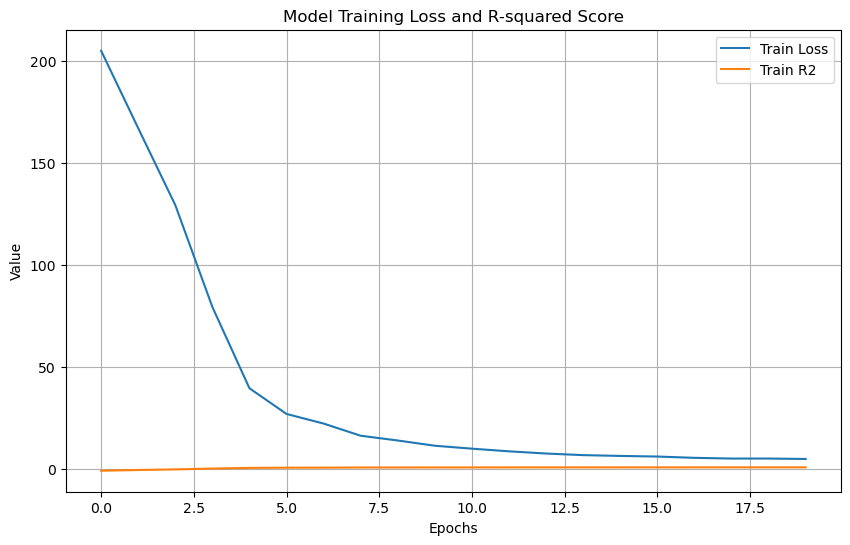

In [1683]:
n_features = 1
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], n_features)

# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))

# model = Sequential()
# model.add(LSTM(100, activation='relu', input_shape=(n_steps, n_features), kernel_regularizer=L2(0.001), return_sequences=True))
# model.add(LSTM(50, activation='relu', kernel_regularizer=L2(0.01)))
# model.add(Dense(1))

def r_squared(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# Compile the model
model.compile(optimizer='adam', 
              loss='mse',
              metrics=[r_squared])

early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

# fit model
history = model.fit(X_train, y_train, 
          epochs = 20,
          batch_size = 32,
          verbose = 0,
          callbacks=[early_stopping])

# Obtain the MSE and R-squared from the last epoch
last_epoch_mse = history.history['loss'][-1]
last_epoch_r_squared = history.history['r_squared'][-1]

# Print the MSE and R-squared
print("Mean Squared Error (MSE) from the last epoch:", last_epoch_mse)
print("R-squared from the last epoch:", last_epoch_r_squared)

# plot loss and r2 score
plt.figure(figsize=(10, 6))

# Plot train loss
plt.plot(history.history['loss'], label='Train Loss')

# Plot train R-squared score
plt.plot(history.history['r_squared'], label='Train R2')

plt.title('Model Training Loss and R-squared Score')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# # Evaluate the model
# loss = model.evaluate(X_test, y_test)
# print("MSE and R_squared:", loss)

# # make prediction on test data
# X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], n_features)
# y_pred = model.predict(X_test)

# # Print the first 5 predictions and actual values
# print("Predictions:")
# flattened_predictions = [pred[0] for pred in y_pred[:10]]
# print(flattened_predictions)
# # print(y_pred[:10].tolist())
# print("Actual values:")
# rounded_actual_values = [round(value, len(str(prediction).split('.')[1])) for value, prediction in zip(y_test[:10], flattened_predictions)]
# print(rounded_actual_values)

# # plot the actual and predicted values for test data
# trace1 = go.Scatter(x=np.arange(len(y_test)), y=y_test.flatten(), mode='lines', name='Actual')
# trace2 = go.Scatter(x=np.arange(len(y_pred)), y=y_pred.flatten(), mode='lines', name='Predicted')

# # Create layout
# layout = go.Layout(
#     title='Quebec: LSTM Univariate Prediction on Mean Max Temp (°C)',
#     xaxis=dict(title='Time step'),
#     yaxis=dict(title='Construction'),
#     legend=dict(x=0, y=1.18)
# )

# # Create figure
# fig = go.Figure(data=[trace1, trace2], layout=layout)

# # Show plot
# fig.show()

(1.6) Saskatchewan

In [1684]:
resampled_SK = df[df['provincename'] == 'Saskatchewan']

# RESAMPLING THE DATASET TO MONTHLY #

# split data into numeric and string
num_cols = resampled_SK.select_dtypes(include = ['number'])

# resample numeric data
resampled = num_cols.resample("M").mean()

In [1685]:
# define a function that will split the sequence into desired number of steps
def split_sequence(df, n_features):
    data = df.values
    X, y = [], []
    for i in range(len(data)):
        end_ix = i + n_features
        if end_ix > len(data) - 1:
            break
        seq_x, seq_y = data[i:end_ix, :], data[end_ix, 0]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

columns = ['Construction', 
            'Transportation and warehousing', 
            'Health care and social assistance', 
            'Agriculture', 
            'Wholesale trade Retail trade', 
            'Mean Max Temp (°C)', 
            'Mean Min Temp (°C)', 
            'Mean Temp (°C)', 
            'Extr Max Temp (°C)', 
            'Extr Min Temp (°C)', 
            'Total Rain (mm)', 
            'Total Snow (cm)', 
            'Total Precip (mm)', 
            'Snow Grnd Last Day (cm)', 
            'Dir of Max Gust (10s deg)', 
            'Spd of Max Gust (km/h)']

            Mean Max Temp (°C)
Date/Time                     
1998-01-31          -12.126696
1998-02-28           -1.101262
1998-03-31           -0.781830
1998-04-30           13.740122
1998-05-31           19.580392


<Axes: title={'center': 'Mean Max Temp (°C)'}, xlabel='Date/Time'>

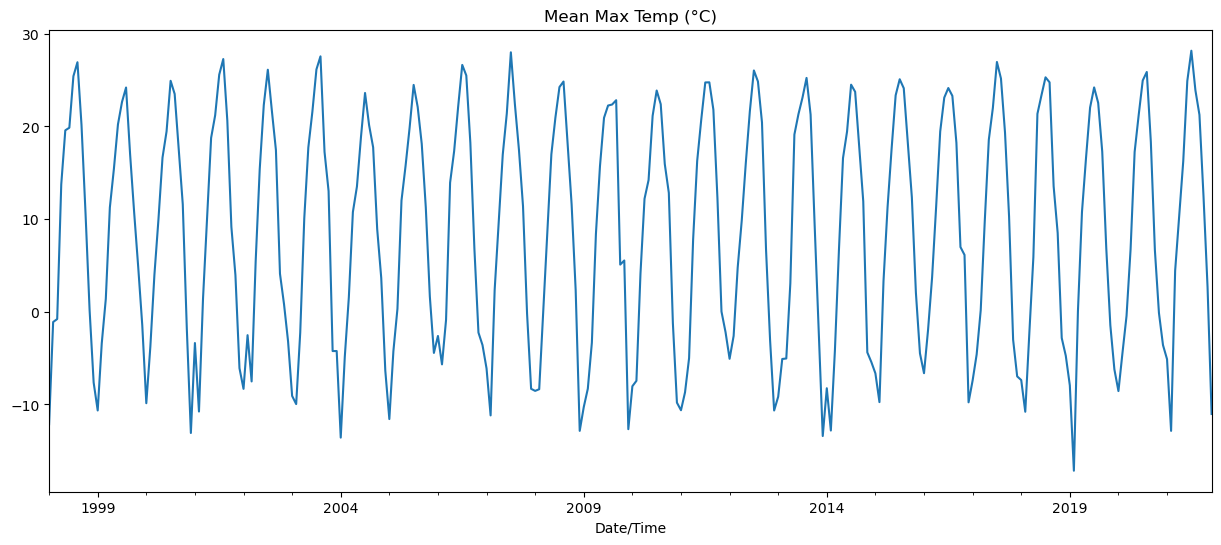

In [1686]:
lstm_data = pd.DataFrame(resampled['Mean Max Temp (°C)'])
print(lstm_data.head(5))
lstm_data['Mean Max Temp (°C)'].plot(title = 'Mean Max Temp (°C)')

In [1687]:
# split into train and test
train_end_date = '2018-12-31'

train_data = lstm_data[lstm_data.index <= train_end_date]
test_data = lstm_data[lstm_data.index > train_end_date]

print(f'Train data:')
print(train_data.index.min())
print(train_data.index.max())
print(f'Test data:')
print(test_data.index.min())
print(test_data.index.max())

# TRAIN DATA #

# number of time steps
n_steps = 7

# split into samples | will have features and target variables
X_train, y_train = split_sequence(train_data, n_steps)

# for i in range(len(X_train)):
#  print(X_train[i], y_train[i])
 
 # TEST DATA #

# split into samples | will have features and target variables
X_test, y_test = split_sequence(test_data, n_steps)

# for i in range(len(X_test)):
#  print(X_test[i], y_test[i])

Train data:
1998-01-31 00:00:00
2018-12-31 00:00:00
Test data:
2019-01-31 00:00:00
2021-12-31 00:00:00


LSTM Model Development

Mean Squared Error (MSE) from the last epoch: 8.726967811584473
R-squared from the last epoch: 0.9413052201271057


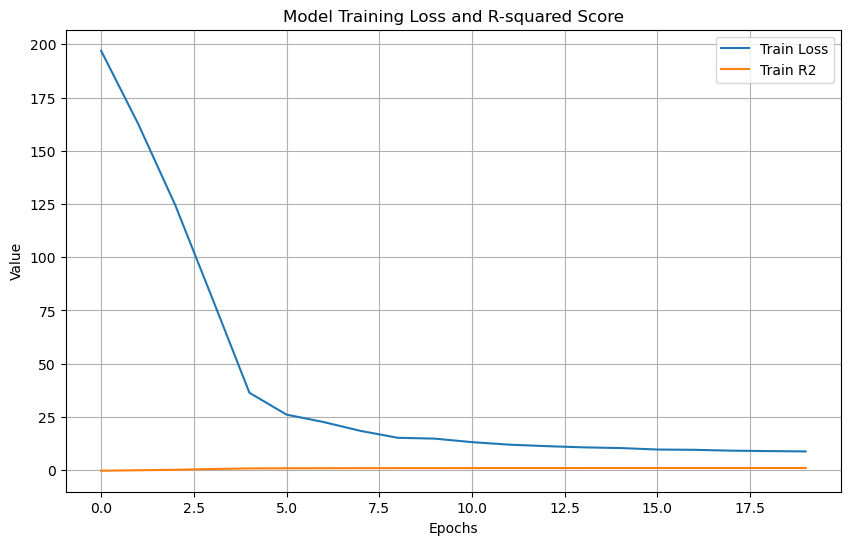

1/1 [==============================] - 0s 215ms/step - loss: 11.8172 - r_squared: 0.9233
MSE and R_squared: [11.817167282104492, 0.9233137369155884]
1/1 [==============================] - 0s 174ms/step
Predictions:
[24.85121, 14.136217, 9.79432, -0.991053, -6.29276, -6.725967, -4.843693, 2.947872, 10.566561, 13.375158]
Actual values:
[22.53997, 17.284993, 6.83546, -1.450736, -6.21288, -8.552655, -4.426743, -0.442349, 6.748355, 17.251091]


In [1688]:
n_features = 1
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], n_features)

# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))

# model = Sequential()
# model.add(LSTM(100, activation='relu', input_shape=(n_steps, n_features), kernel_regularizer=L2(0.001), return_sequences=True))
# model.add(LSTM(50, activation='relu', kernel_regularizer=L2(0.01)))
# model.add(Dense(1))

def r_squared(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# Compile the model
model.compile(optimizer='adam', 
              loss='mse',
              metrics=[r_squared])

early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

# fit model
history = model.fit(X_train, y_train, 
          epochs = 20,
          batch_size = 32,
          verbose = 0,
          callbacks=[early_stopping])

# Obtain the MSE and R-squared from the last epoch
last_epoch_mse = history.history['loss'][-1]
last_epoch_r_squared = history.history['r_squared'][-1]

# Print the MSE and R-squared
print("Mean Squared Error (MSE) from the last epoch:", last_epoch_mse)
print("R-squared from the last epoch:", last_epoch_r_squared)

# plot loss and r2 score
plt.figure(figsize=(10, 6))

# Plot train loss
plt.plot(history.history['loss'], label='Train Loss')

# Plot train R-squared score
plt.plot(history.history['r_squared'], label='Train R2')

plt.title('Model Training Loss and R-squared Score')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print("MSE and R_squared:", loss)

# make prediction on test data
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], n_features)
y_pred = model.predict(X_test)

# Print the first 5 predictions and actual values
print("Predictions:")
flattened_predictions = [pred[0] for pred in y_pred[:10]]
print(flattened_predictions)
# print(y_pred[:10].tolist())
print("Actual values:")
rounded_actual_values = [round(value, len(str(prediction).split('.')[1])) for value, prediction in zip(y_test[:10], flattened_predictions)]
print(rounded_actual_values)

# plot the actual and predicted values for test data
trace1 = go.Scatter(x=np.arange(len(y_test)), y=y_test.flatten(), mode='lines', name='Actual')
trace2 = go.Scatter(x=np.arange(len(y_pred)), y=y_pred.flatten(), mode='lines', name='Predicted')

# Create layout
layout = go.Layout(
    title='Saskatchewan: LSTM Univariate Prediction on Mean Max Temp (°C)',
    xaxis=dict(title='Time step'),
    yaxis=dict(title='Construction'),
    legend=dict(x=0, y=1.18)
)

# Create figure
fig = go.Figure(data=[trace1, trace2], layout=layout)

# Show plot
fig.show()

## (2) Multivariate ##

In [1689]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (15, 6)
mpl.rcParams['axes.grid'] = False

In [1690]:
columns = [
    'Mean Max Temp (°C)',
    'Mean Min Temp (°C)',
    'Mean Temp (°C)',
    'Extr Max Temp (°C)',
    'Extr Min Temp (°C)',
    'Total Rain (mm)',
    'Total Snow (cm)',
    'Total Precip (mm)',
    'Snow Grnd Last Day (cm)',
    'Dir of Max Gust (10s deg)',
    'Spd of Max Gust (km/h)'
]

(2.1) Combination of all 5 provinces

In [1691]:
# RESAMPLING THE DATASET TO MONTHLY #

# split data into numeric and string
num_cols = df.select_dtypes(include = ['number'])

# resample numeric data
resampled = num_cols.resample("M").mean()

In [1692]:
resampled = resampled[columns]
resampled.head()


,Mean Max Temp (°C),Mean Min Temp (°C),Mean Temp (°C),Extr Max Temp (°C),Extr Min Temp (°C),Total Rain (mm),Total Snow (cm),Total Precip (mm),Snow Grnd Last Day (cm),Dir of Max Gust (10s deg),Spd of Max Gust (km/h)
Date/Time,,,,,,,,,,,
1998-01-31,-3.476795,-11.475936,-7.483320,7.229147,-25.824194,62.171390,30.895640,102.139782,16.223433,0.498638,1.321526
1998-02-28,2.335362,-6.219163,-1.968022,8.785487,-16.149888,43.465123,9.188011,57.897275,14.411444,0.370572,1.049046
1998-03-31,4.270940,-5.059074,-0.388330,15.420638,-16.974551,43.057493,17.122616,65.206267,5.264305,0.326975,1.237057
1998-04-30,12.866301,0.774230,6.834755,23.147497,-4.935786,34.318699,2.743902,39.689702,0.143631,0.382114,1.281843
1998-05-31,19.732610,6.950949,13.355348,27.606341,0.251378,48.026216,0.022973,53.502432,0.000000,0.491892,1.432432


array([<Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>], dtype=object)

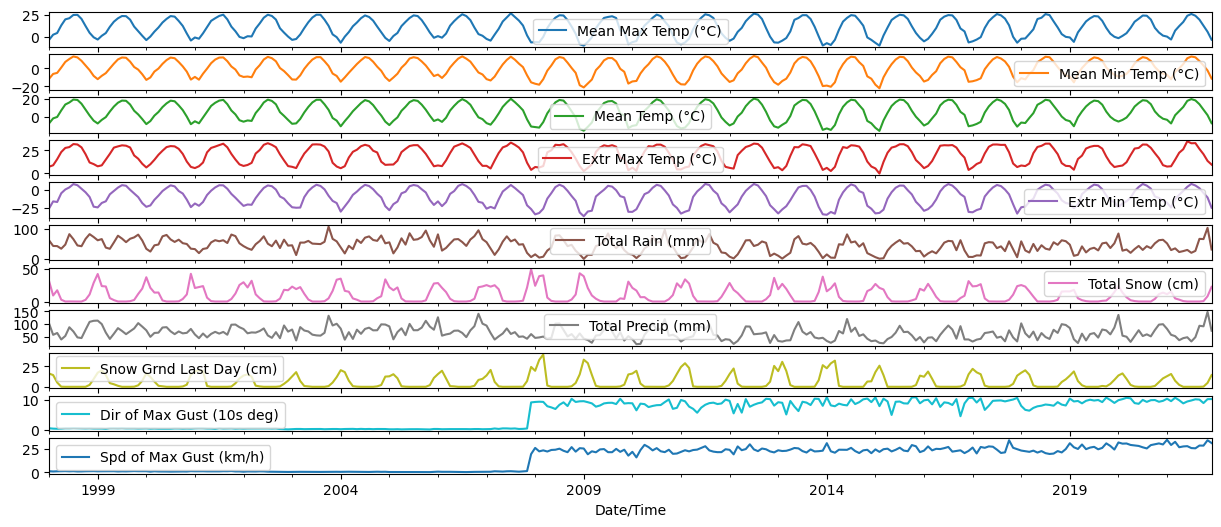

In [1693]:
resampled[['Mean Max Temp (°C)',
    'Mean Min Temp (°C)',
    'Mean Temp (°C)',
    'Extr Max Temp (°C)',
    'Extr Min Temp (°C)',
    'Total Rain (mm)',
    'Total Snow (cm)',
    'Total Precip (mm)',
    'Snow Grnd Last Day (cm)',
    'Dir of Max Gust (10s deg)',
    'Spd of Max Gust (km/h)']].plot(subplots = True)

In [1694]:
# split into train and test
train_end_date = '2018-12-31'

train_data = resampled[resampled.index <= train_end_date]
test_data = resampled[resampled.index > train_end_date]

print(f'Train data:')
print(train_data.index.min())
print(train_data.index.max())
print(train_data.shape)
print(f'Test data:')
print(test_data.index.min())
print(test_data.index.max())
print(test_data.shape)

Train data:
1998-01-31 00:00:00
2018-12-31 00:00:00
(252, 11)
Test data:
2019-01-31 00:00:00
2021-12-31 00:00:00
(36, 11)


In [1695]:
train_data_array = train_data.values
print(train_data_array[0])
print(train_data_array.shape)

test_data_array = test_data.values
print(test_data_array[0])
print(test_data_array.shape)


[ -3.4767949 -11.4759355  -7.4833201   7.2291474 -25.8241937  62.1713896
  30.8956403 102.139782   16.2234332   0.4986376   1.3215259]
(252, 11)
[ -0.7958414  -9.1655219  -5.0491491   7.8297607 -19.6134514  47.7203226
  15.3487097  84.6512903  13.7129032  10.5096774  30.7774194]
(36, 11)


In [1696]:
def split_to_train_test(dataset,n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
            dataX.append(dataset[i - n_past:i, 1:dataset.shape[1]])
            dataY.append(dataset[i-n_past,0])
    return np.array(dataX),np.array(dataY)    

In [1697]:
time_steps = 1

# TRAIN
X_train, y_train = split_to_train_test(train_data_array, time_steps)
print('Before reshape:')
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)

X_train = X_train.reshape(-1, X_train.shape[-1])
print('After reshape:')
print('X_train:', X_train.shape)

y_train = y_train.reshape((-1, 1))
print('y_train:', y_train.shape)

# TEST
X_test, y_test = split_to_train_test(test_data_array, time_steps)
print('Before reshape:')
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)

X_test = X_test.reshape(-1, X_train.shape[-1])
print('After reshape:')
print('X_test:', X_test.shape)

y_test = y_test.reshape((-1, 1))
print('y_test:', y_test.shape)

Before reshape:
X_train: (251, 1, 10)
y_train: (251,)
After reshape:
X_train: (251, 10)
y_train: (251, 1)
Before reshape:
X_test: (35, 1, 10)
y_test: (35,)
After reshape:
X_test: (35, 10)
y_test: (35, 1)


In [1698]:
train_data_array[0]

array([ -3.4767949, -11.4759355,  -7.4833201,   7.2291474, -25.8241937,
        62.1713896,  30.8956403, 102.139782 ,  16.2234332,   0.4986376,
         1.3215259])

In [1699]:
X_train[0]

array([-11.4759355,  -7.4833201,   7.2291474, -25.8241937,  62.1713896,
        30.8956403, 102.139782 ,  16.2234332,   0.4986376,   1.3215259])

In [1700]:
y_train[0]

array([-3.4767949])

In [1701]:
scaler_1 = StandardScaler()
np.set_printoptions(precision=7)
X_train_scaled = scaler_1.fit_transform(X_train)
print('X_train_scaled:', X_train_scaled[0])
print('X_train_scaled:', X_train_scaled.shape)

scaler_2 = StandardScaler()
y_train_scaled = scaler_2.fit_transform(y_train)
print('y_train_scaled:', y_train_scaled[0:5])
print('y_train_scaled:', y_train_scaled.shape)

scaler_3 = StandardScaler()
X_test_scaled = scaler_3.fit_transform(X_test)
print('X_test_scaled:', X_test_scaled[0])
print('X_test_scaled:', X_test_scaled.shape)

scaler_4 = StandardScaler()
y_test_scaled = scaler_4.fit_transform(y_test)
print('y_test_scaled:', y_test_scaled[0:5])
print('y_test_scaled:', y_test_scaled.shape)

X_train_scaled: [-1.1357945 -1.2126971 -1.3017805 -1.2614144  0.7435674  1.77102
  1.6211229  1.1663778 -0.987954  -1.0044652]
X_train_scaled: (251, 10)
y_train_scaled: [[-1.2717802]
 [-0.735527 ]
 [-0.5569428]
 [ 0.2361   ]
 [ 0.8696135]]
y_train_scaled: (251, 1)
X_test_scaled: [-1.296014  -1.3105855 -1.3397386 -1.2157613  0.3275578  1.580004
  0.6994622  1.5856543  1.1749361  0.9783127]
X_test_scaled: (35, 10)
y_test_scaled: [[-1.3089023]
 [-1.8400033]
 [-0.6994833]
 [-0.0388481]
 [ 0.6195921]]
y_test_scaled: (35, 1)


In [1702]:
y_train_scaled

array([[-1.2717802],
       [-0.735527 ],
       [-0.5569428],
       [ 0.2361   ],
       [ 0.8696135],
       [ 0.9895308],
       [ 1.3320688],
       [ 1.3441756],
       [ 0.918344 ],
       [ 0.1729711],
       [-0.5398424],
       [-1.0077899],
       [-1.2440465],
       [-0.852818 ],
       [-0.5634675],
       [ 0.089542 ],
       [ 0.6287383],
       [ 0.981145 ],
       [ 1.2198372],
       [ 1.2051016],
       [ 0.8413229],
       [ 0.1139158],
       [-0.3722852],
       [-0.8485119],
       [-1.3009885],
       [-0.9292445],
       [-0.4146408],
       [ 0.0181606],
       [ 0.5416303],
       [ 0.9181451],
       [ 1.2147935],
       [ 1.1563226],
       [ 0.7035553],
       [ 0.1815878],
       [-0.6116059],
       [-1.3463924],
       [-1.0272307],
       [-1.1585327],
       [-0.5916896],
       [ 0.0524276],
       [ 0.7143108],
       [ 0.9852793],
       [ 1.2305332],
       [ 1.357971 ],
       [ 0.8707647],
       [ 0.1083263],
       [-0.3743119],
       [-0.96

In [1703]:
X_train_scaled = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
X_test_scaled = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])
print('X_train:', X_train.shape)
print('X_test:', X_test.shape)

X_train: (251, 10)
X_test: (35, 10)


Model: "sequential_171"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_228 (LSTM)             (None, 1, 128)            71168     
                                                                 
 dropout_114 (Dropout)       (None, 1, 128)            0         
                                                                 
 lstm_229 (LSTM)             (None, 128)               131584    
                                                                 
 dropout_115 (Dropout)       (None, 128)               0         
                                                                 
 dense_171 (Dense)           (None, 1)                 129       
                                                                 
Total params: 202881 (792.50 KB)
Trainable params: 202881 (792.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Train Mean S

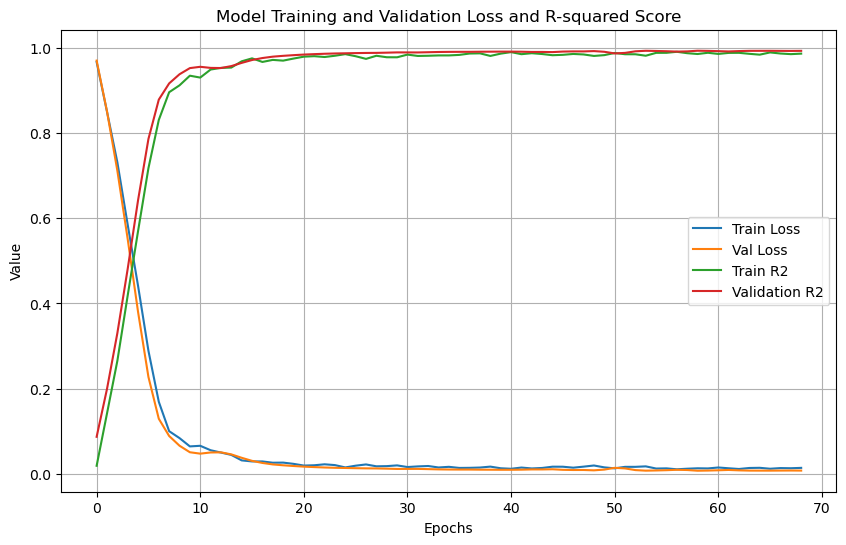

In [1704]:
from keras.optimizers import Adam

# initialize model
# model = Sequential()
# model.add(LSTM(50, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
# model.add(Dropout(0.2))
# model.add(Dense(1))

model = Sequential()
model.add(LSTM(128, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]), return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(128))
model.add(Dropout(0.3))
model.add(Dense(1))

def r_squared(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# Compile the model
optimizer = Adam(learning_rate = 0.001)
model.compile(optimizer=optimizer, 
              loss='mse',
              metrics=[r_squared])

model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# fit model
history = model.fit(X_train_scaled, y_train_scaled,
          epochs = 100,
          batch_size = 64,
          verbose = 0,
          callbacks=[early_stopping],
          shuffle = False,
          validation_split = 0.2)

# Obtain the MSE and R-squared from the last epoch
last_epoch_mse = history.history['loss'][-1]
last_epoch_r_squared = history.history['r_squared'][-1]
last_epoch_mse_val = history.history['val_loss'][-1]
last_epoch_r_squared_val = history.history['val_r_squared'][-1]

# Print the MSE and R-squared
print("Train Mean Squared Error (MSE) from the last epoch:", last_epoch_mse)
print("Train R-squared from the last epoch:", last_epoch_r_squared)
print("Val Mean Squared Error (MSE) from the last epoch:", last_epoch_mse_val)
print("Val R-squared from the last epoch:", last_epoch_r_squared_val)

# plot loss and r2 score
plt.figure(figsize=(10, 6))

# Plot train loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')

# Plot train R-squared score
plt.plot(history.history['r_squared'], label='Train R2')
plt.plot(history.history['val_r_squared'], label='Validation R2')

plt.title('Model Training and Validation Loss and R-squared Score')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [1705]:
# Evaluate the model
loss = model.evaluate(X_test_scaled, y_test_scaled)
print("MSE and R_squared:", loss)

2/2 [==============================] - 0s 6ms/step - loss: 0.0071 - r_squared: 0.9921
MSE and R_squared: [0.007079141214489937, 0.9921489953994751]


In [1706]:
train_predict = model.predict(X_train_scaled)
test_predict = model.predict(X_test_scaled)
print('train_predict:', train_predict.shape)
print('test_predict:', test_predict.shape)

2/2 [==============================] - 0s 6ms/step
train_predict: (251, 1)
test_predict: (35, 1)


In [1707]:
# invert predictions
train_predict = scaler_2.inverse_transform(train_predict)
print('train_predict:', train_predict.shape)

# invert y_train
y_train_scaled_inversed = scaler_2.inverse_transform(y_train_scaled)
print('y_train_scaled_inversed:', y_train_scaled_inversed.shape)

train_predict: (251, 1)
y_train_scaled_inversed: (251, 1)


In [1708]:
train_predict[0:10]

array([[-2.9924574],
       [ 2.2294598],
       [ 4.251726 ],
       [13.587765 ],
       [19.640371 ],
       [21.43807  ],
       [25.00569  ],
       [24.478918 ],
       [20.708948 ],
       [13.44191  ]], dtype=float32)

In [1709]:
print('Train Mean Absolute Error:', mean_absolute_error(y_train, train_predict))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(y_train, train_predict)))

# plot the actual and predicted values for test data
trace1 = go.Scatter(x=np.arange(len(y_train)), y=y_train.flatten(), mode='lines', name='Actual Train')
trace2 = go.Scatter(x=np.arange(len(train_predict)), y=train_predict.flatten(), mode='lines', name='Predicted Train')

# Create layout
layout = go.Layout(
    title='LSTM Prediction on Mean Max Temp (°C)',
    xaxis=dict(title='Time step'),
    yaxis=dict(title='Mean Max Temp Values'),
    legend=dict(x=0, y=1.18)
)

# Create figure
fig = go.Figure(data=[trace1, trace2], layout=layout)

# Show plot
fig.show()

Train Mean Absolute Error: 0.6145200749929811
Train Root Mean Squared Error: 0.7886837324769389


In [1710]:
# invert predictions
test_predict = scaler_4.inverse_transform(test_predict)
print('test_predict:', test_predict.shape)

# invert y_test
y_test_scaled_inversed = scaler_4.inverse_transform(y_test_scaled)
print('y_test_scaled_inversed:', y_test_scaled_inversed.shape)

test_predict: (35, 1)
y_test_scaled_inversed: (35, 1)


In [1711]:
print('Test Mean Absolute Error:', mean_absolute_error(y_test, test_predict))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(y_test, test_predict)))

# plot the actual and predicted values for test data
trace1 = go.Scatter(x=np.arange(len(y_test)), y=y_test.flatten(), mode='lines', name='Actual Test')
trace2 = go.Scatter(x=np.arange(len(test_predict)), y=test_predict.flatten(), mode='lines', name='Predicted Test')

# Create layout
layout = go.Layout(
    title='LSTM Prediction on Mean Max Temp (°C)',
    xaxis=dict(title='Time step'),
    yaxis=dict(title='Mean Max Temp Values'),
    legend=dict(x=0, y=1.18)
)

# Create figure
fig = go.Figure(data=[trace1, trace2], layout=layout)

# Show plot
fig.show()

Test Mean Absolute Error: 0.5994148899778099
Test Root Mean Squared Error: 0.7941831542838453


(2.2) Alberta

In [1712]:
resampled_AB = df[df['provincename'] == 'Alberta']

# RESAMPLING THE DATASET TO MONTHLY #

# split data into numeric and string
num_cols = resampled_AB.select_dtypes(include = ['number'])

# resample numeric data
resampled = num_cols.resample("M").mean()

resampled = resampled[columns]
resampled.head()


,Mean Max Temp (°C),Mean Min Temp (°C),Mean Temp (°C),Extr Max Temp (°C),Extr Min Temp (°C),Total Rain (mm),Total Snow (cm),Total Precip (mm),Snow Grnd Last Day (cm),Dir of Max Gust (10s deg),Spd of Max Gust (km/h)
Date/Time,,,,,,,,,,,
1998-01-31,-9.174123,-19.446359,-14.327202,7.285181,-36.542816,0.085185,16.261111,15.305556,7.611111,1.388889,2.129630
1998-02-28,1.726643,-9.481329,-3.892085,9.294639,-18.085026,0.059259,2.807407,2.512963,6.018519,0.240741,0.685185
1998-03-31,2.130065,-9.171270,-3.530172,13.286094,-24.753519,1.240741,23.177778,21.712963,2.666667,0.907407,2.814815
1998-04-30,13.155375,-0.826884,6.184374,22.869606,-6.995261,14.363636,5.376364,20.041818,0.000000,0.563636,3.236364
1998-05-31,20.054474,4.686848,12.396424,27.039213,-1.883615,48.781818,0.000000,49.996364,0.000000,1.636364,4.363636


array([<Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>], dtype=object)

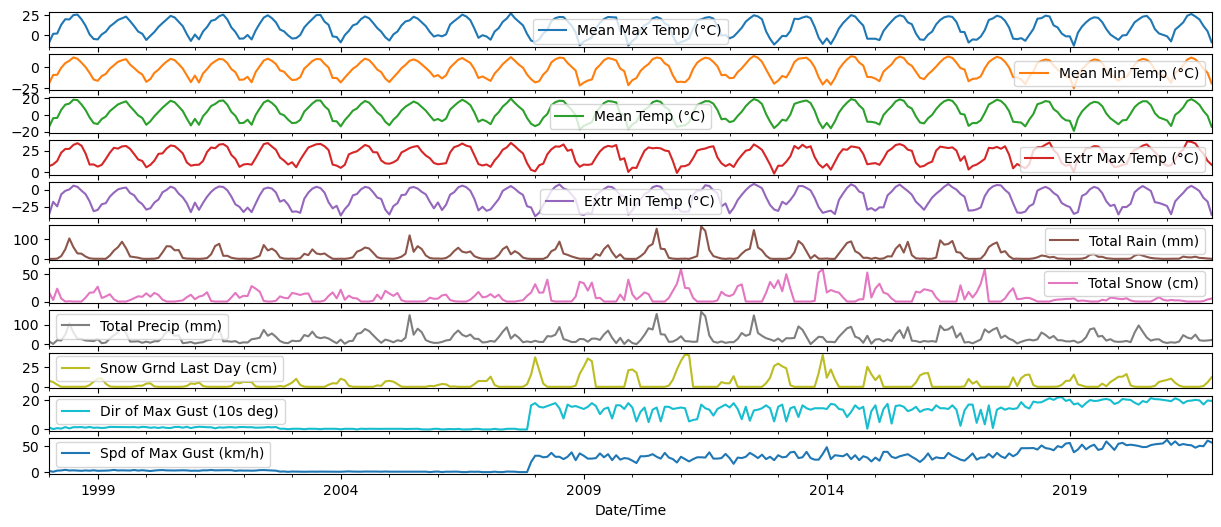

In [1713]:
resampled[['Mean Max Temp (°C)',
    'Mean Min Temp (°C)',
    'Mean Temp (°C)',
    'Extr Max Temp (°C)',
    'Extr Min Temp (°C)',
    'Total Rain (mm)',
    'Total Snow (cm)',
    'Total Precip (mm)',
    'Snow Grnd Last Day (cm)',
    'Dir of Max Gust (10s deg)',
    'Spd of Max Gust (km/h)']].plot(subplots = True)

In [1714]:
# split into train and test
train_end_date = '2018-12-31'

train_data = resampled[resampled.index <= train_end_date]
test_data = resampled[resampled.index > train_end_date]

print(f'Train data:')
print(train_data.index.min())
print(train_data.index.max())
print(train_data.shape)
print(f'Test data:')
print(test_data.index.min())
print(test_data.index.max())
print(test_data.shape)

Train data:
1998-01-31 00:00:00
2018-12-31 00:00:00
(252, 11)
Test data:
2019-01-31 00:00:00
2021-12-31 00:00:00
(36, 11)


In [1715]:
train_data_array = train_data.values
print(train_data_array[0])
print(train_data_array.shape)

test_data_array = test_data.values
print(test_data_array[0])
print(test_data_array.shape)


[ -9.1741231 -19.4463592 -14.3272019   7.285181  -36.5428164   0.0851852
  16.2611111  15.3055556   7.6111111   1.3888889   2.1296296]
(252, 11)
[ -1.4613454 -12.5655971  -7.0306553   9.4530861 -25.7238998   0.2216667
   4.7733333  15.1466667   7.8        20.3166667  56.1333333]
(36, 11)


In [1716]:
def split_to_train_test(dataset,n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
            dataX.append(dataset[i - n_past:i, 1:dataset.shape[1]])
            dataY.append(dataset[i - n_past,0])
    return np.array(dataX),np.array(dataY)    

In [1717]:
time_steps = 1

# TRAIN
X_train, y_train = split_to_train_test(train_data_array, time_steps)
print('Before reshape:')
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)

X_train = X_train.reshape(-1, X_train.shape[-1])
print('After reshape:')
print('X_train:', X_train.shape)

y_train = y_train.reshape((-1, 1))
print('y_train:', y_train.shape)

# TEST
X_test, y_test = split_to_train_test(test_data_array, time_steps)
print('Before reshape:')
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)

X_test = X_test.reshape(-1, X_train.shape[-1])
print('After reshape:')
print('X_test:', X_test.shape)

y_test = y_test.reshape((-1, 1))
print('y_test:', y_test.shape)

Before reshape:
X_train: (251, 1, 10)
y_train: (251,)
After reshape:
X_train: (251, 10)
y_train: (251, 1)
Before reshape:
X_test: (35, 1, 10)
y_test: (35,)
After reshape:
X_test: (35, 10)
y_test: (35, 1)


In [1718]:
scaler_1 = StandardScaler()
np.set_printoptions(precision=7)
X_train_scaled = scaler_1.fit_transform(X_train)
print('X_train_scaled:', X_train_scaled[0])
print('X_train_scaled:', X_train_scaled.shape)

scaler_2 = StandardScaler()
y_train_scaled = scaler_2.fit_transform(y_train)
print('y_train_scaled:', y_train_scaled[0:5])
print('y_train_scaled:', y_train_scaled.shape)

scaler_3 = StandardScaler()
X_test_scaled = scaler_3.fit_transform(X_test)
print('X_test_scaled:', X_test_scaled[0])
print('X_test_scaled:', X_test_scaled.shape)

scaler_4 = StandardScaler()
y_test_scaled = scaler_4.fit_transform(y_test)
print('y_test_scaled:', y_test_scaled[0:5])
print('y_test_scaled:', y_test_scaled.shape)

X_train_scaled: [-1.7515246 -1.7150983 -1.3000149 -1.7867537 -0.7700451  0.5765474
 -0.6783407  0.3928021 -0.8713735 -0.9757997]
X_train_scaled: (251, 10)
y_train_scaled: [[-1.6739818]
 [-0.6871941]
 [-0.6506745]
 [ 0.3473876]
 [ 0.9719259]]
y_train_scaled: (251, 1)
X_test_scaled: [-1.050581  -1.0760292 -1.1450345 -0.9786855 -0.8188307  1.0999696
 -0.6778062  0.7844273  0.6892207  0.912444 ]
X_test_scaled: (35, 10)
y_test_scaled: [[-1.0918812]
 [-2.1894585]
 [-0.6593792]
 [ 0.0663566]
 [ 0.5699932]]
y_test_scaled: (35, 1)


In [1719]:
X_train_scaled = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
X_test_scaled = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])
print('X_train:', X_train.shape)
print('X_test:', X_test.shape)

X_train: (251, 10)
X_test: (35, 10)


Model: "sequential_172"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_230 (LSTM)             (None, 1, 128)            71168     
                                                                 
 dropout_116 (Dropout)       (None, 1, 128)            0         
                                                                 
 lstm_231 (LSTM)             (None, 128)               131584    
                                                                 
 dropout_117 (Dropout)       (None, 128)               0         
                                                                 
 dense_172 (Dense)           (None, 1)                 129       
                                                                 
Total params: 202881 (792.50 KB)
Trainable params: 202881 (792.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Train Mean S

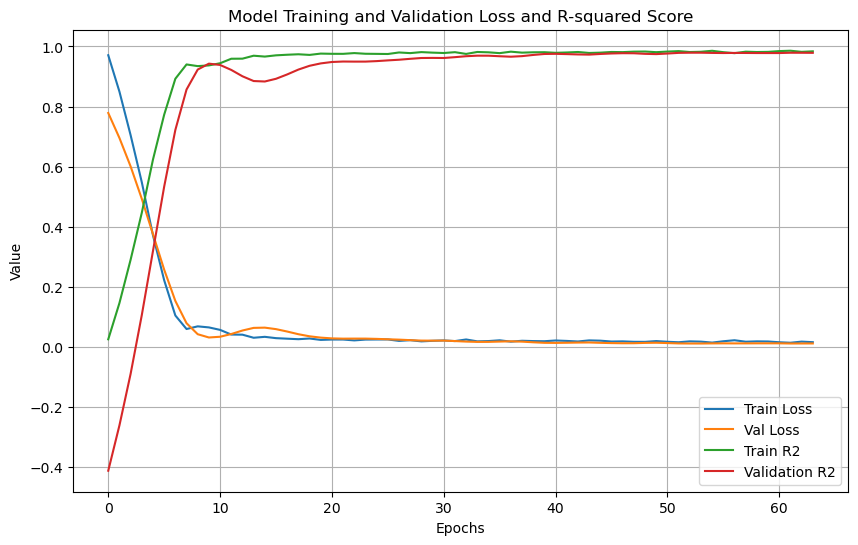

In [1720]:
from keras.optimizers import Adam

# initialize model
# model = Sequential()
# model.add(LSTM(50, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
# model.add(Dropout(0.2))
# model.add(Dense(1))

model = Sequential()
model.add(LSTM(128, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]), return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(128))
model.add(Dropout(0.3))
model.add(Dense(1))

def r_squared(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# Compile the model
optimizer = Adam(lr=0.001)
model.compile(optimizer=optimizer, 
              loss='mse',
              metrics=[r_squared])

model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# fit model
history = model.fit(X_train_scaled, y_train_scaled,
          epochs = 100,
          batch_size = 64,
          verbose = 0,
          callbacks=[early_stopping],
          shuffle = False,
          validation_split = 0.02)

# Obtain the MSE and R-squared from the last epoch
last_epoch_mse = history.history['loss'][-1]
last_epoch_r_squared = history.history['r_squared'][-1]
last_epoch_mse_val = history.history['val_loss'][-1]
last_epoch_r_squared_val = history.history['val_r_squared'][-1]

# Print the MSE and R-squared
print("Train Mean Squared Error (MSE) from the last epoch:", last_epoch_mse)
print("Train R-squared from the last epoch:", last_epoch_r_squared)
print("Val Mean Squared Error (MSE) from the last epoch:", last_epoch_mse_val)
print("Val R-squared from the last epoch:", last_epoch_r_squared_val)

# plot loss and r2 score
plt.figure(figsize=(10, 6))

# Plot train loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')

# Plot train R-squared score
plt.plot(history.history['r_squared'], label='Train R2')
plt.plot(history.history['val_r_squared'], label='Validation R2')

plt.title('Model Training and Validation Loss and R-squared Score')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [1721]:
# Evaluate the model
loss = model.evaluate(X_test_scaled, y_test_scaled)
print("MSE and R_squared:", loss)

2/2 [==============================] - 0s 2ms/step - loss: 0.0101 - r_squared: 0.9848
MSE and R_squared: [0.010050917975604534, 0.9848021268844604]


In [1722]:
train_predict = model.predict(X_train_scaled)
test_predict = model.predict(X_test_scaled)
print('train_predict:', train_predict.shape)
print('test_predict:', test_predict.shape)

2/2 [==============================] - 0s 10ms/step
train_predict: (251, 1)
test_predict: (35, 1)


In [1723]:
# invert predictions
train_predict = scaler_2.inverse_transform(train_predict)
print('train_predict:', train_predict.shape)

# invert y_train
y_train_scaled_inversed = scaler_2.inverse_transform(y_train_scaled)
print('y_train_scaled_inversed:', y_train_scaled_inversed.shape)

print('Train Mean Absolute Error:', mean_absolute_error(y_train, train_predict))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(y_train, train_predict)))

# plot the actual and predicted values for test data
trace1 = go.Scatter(x=np.arange(len(y_train)), y=y_train.flatten(), mode='lines', name='Actual Train')
trace2 = go.Scatter(x=np.arange(len(train_predict)), y=train_predict.flatten(), mode='lines', name='Predicted Train')

# Create layout
layout = go.Layout(
    title='Alberta: LSTM Prediction on Mean Max Temp (°C)',
    xaxis=dict(title='Time step'),
    yaxis=dict(title='Mean Max Temp Values'),
    legend=dict(x=0, y=1.18)
)

# Create figure
fig = go.Figure(data=[trace1, trace2], layout=layout)

# Show plot
fig.show()

train_predict: (251, 1)
y_train_scaled_inversed: (251, 1)
Train Mean Absolute Error: 0.7391748193476192
Train Root Mean Squared Error: 0.9501288885927118


In [1724]:
# invert predictions
test_predict = scaler_4.inverse_transform(test_predict)
print('test_predict:', test_predict.shape)

# invert y_test
y_test_scaled_inversed = scaler_4.inverse_transform(y_test_scaled)
print('y_test_scaled_inversed:', y_test_scaled_inversed.shape)

print('Test Mean Absolute Error:', mean_absolute_error(y_test, test_predict))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(y_test, test_predict)))

# plot the actual and predicted values for test data
trace1 = go.Scatter(x=np.arange(len(y_test)), y=y_test.flatten(), mode='lines', name='Actual Test')
trace2 = go.Scatter(x=np.arange(len(test_predict)), y=test_predict.flatten(), mode='lines', name='Predicted Test')

# Create layout
layout = go.Layout(
    title='Alberta: LSTM Prediction on Mean Max Temp (°C)',
    xaxis=dict(title='Time step'),
    yaxis=dict(title='Mean Max Temp Values'),
    legend=dict(x=0, y=1.18)
)

# Create figure
fig = go.Figure(data=[trace1, trace2], layout=layout)

# Show plot
fig.show()

test_predict: (35, 1)
y_test_scaled_inversed: (35, 1)
Test Mean Absolute Error: 0.7887876116779463
Test Root Mean Squared Error: 1.0614559075641607


(2.3) Bristish Columbia

In [1725]:
resampled_BC = df[df['provincename'] == 'British Columbia']

# RESAMPLING THE DATASET TO MONTHLY #

# split data into numeric and string
num_cols = resampled_BC.select_dtypes(include = ['number'])

# resample numeric data
resampled = num_cols.resample("M").mean()

resampled = resampled[columns]
resampled.head()

,Mean Max Temp (°C),Mean Min Temp (°C),Mean Temp (°C),Extr Max Temp (°C),Extr Min Temp (°C),Total Rain (mm),Total Snow (cm),Total Precip (mm),Snow Grnd Last Day (cm),Dir of Max Gust (10s deg),Spd of Max Gust (km/h)
Date/Time,,,,,,,,,,,
1998-01-31,1.668112,-4.154257,-1.238191,9.430297,-17.129487,136.186364,33.692424,191.862121,11.113636,0.234848,1.409091
1998-02-28,5.952033,-0.389383,2.724369,10.398405,-6.490740,100.753030,9.244697,122.815152,12.719697,0.234848,1.431818
1998-03-31,8.189304,0.355152,4.292350,14.542492,-6.209205,70.272727,7.814394,90.611364,7.219697,0.234848,0.969697
1998-04-30,13.038331,2.417762,7.737061,23.675751,-2.323696,45.203030,2.137879,53.328788,0.075758,0.234848,0.954545
1998-05-31,18.087071,7.296346,12.687342,26.394613,2.266207,50.971429,0.001504,63.715038,0.000000,0.210526,0.759398


array([<Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>], dtype=object)

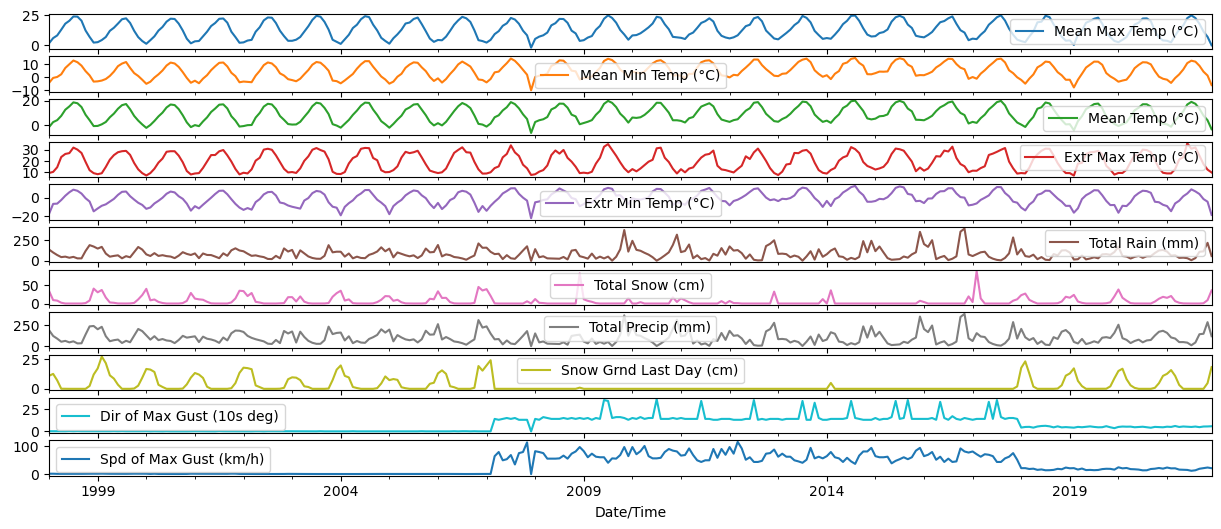

In [1726]:
resampled[['Mean Max Temp (°C)',
    'Mean Min Temp (°C)',
    'Mean Temp (°C)',
    'Extr Max Temp (°C)',
    'Extr Min Temp (°C)',
    'Total Rain (mm)',
    'Total Snow (cm)',
    'Total Precip (mm)',
    'Snow Grnd Last Day (cm)',
    'Dir of Max Gust (10s deg)',
    'Spd of Max Gust (km/h)']].plot(subplots = True)

In [1727]:
# split into train and test
train_end_date = '2018-12-31'

train_data = resampled[resampled.index <= train_end_date]
test_data = resampled[resampled.index > train_end_date]

print(f'Train data:')
print(train_data.index.min())
print(train_data.index.max())
print(train_data.shape)
print(f'Test data:')
print(test_data.index.min())
print(test_data.index.max())
print(test_data.shape)

Train data:
1998-01-31 00:00:00
2018-12-31 00:00:00
(252, 11)
Test data:
2019-01-31 00:00:00
2021-12-31 00:00:00
(36, 11)


In [1728]:
train_data_array = train_data.values
print(train_data_array[0])
print(train_data_array.shape)

test_data_array = test_data.values
print(test_data_array[0])
print(test_data_array.shape)


[  1.6681116  -4.1542568  -1.2381905   9.430297  -17.1294871 136.1863636
  33.6924242 191.8621212  11.1136364   0.2348485   1.4090909]
(252, 11)
[  4.04858    -1.7963335   1.0206015   9.3222218  -8.5824082  99.6887324
  15.6619718 150.7197183  13.0985915   4.5704225  21.0704225]
(36, 11)


In [1729]:
def split_to_train_test(dataset,n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
            dataX.append(dataset[i - n_past:i, 1:dataset.shape[1]])
            dataY.append(dataset[i,0])
    return np.array(dataX),np.array(dataY)    

In [1730]:
time_steps = 1

# TRAIN
X_train, y_train = split_to_train_test(train_data_array, time_steps)
print('Before reshape:')
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)

X_train = X_train.reshape(-1, X_train.shape[-1])
print('After reshape:')
print('X_train:', X_train.shape)

y_train = y_train.reshape((-1, 1))
print('y_train:', y_train.shape)

# TEST
X_test, y_test = split_to_train_test(test_data_array, time_steps)
print('Before reshape:')
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)

X_test = X_test.reshape(-1, X_train.shape[-1])
print('After reshape:')
print('X_test:', X_test.shape)

y_test = y_test.reshape((-1, 1))
print('y_test:', y_test.shape)

Before reshape:
X_train: (251, 1, 10)
y_train: (251,)
After reshape:
X_train: (251, 10)
y_train: (251, 1)
Before reshape:
X_test: (35, 1, 10)
y_test: (35,)
After reshape:
X_test: (35, 10)
y_test: (35, 1)


In [1731]:
scaler_1 = StandardScaler()
np.set_printoptions(precision=7)
X_train_scaled = scaler_1.fit_transform(X_train)
print('X_train_scaled:', X_train_scaled[0])
print('X_train_scaled:', X_train_scaled.shape)

scaler_2 = StandardScaler()
y_train_scaled = scaler_2.fit_transform(y_train)
print('y_train_scaled:', y_train_scaled[0:5])
print('y_train_scaled:', y_train_scaled.shape)

scaler_3 = StandardScaler()
X_test_scaled = scaler_3.fit_transform(X_test)
print('X_test_scaled:', X_test_scaled[0])
print('X_test_scaled:', X_test_scaled.shape)

scaler_4 = StandardScaler()
y_test_scaled = scaler_4.fit_transform(y_test)
print('y_test_scaled:', y_test_scaled[0:5])
print('y_test_scaled:', y_test_scaled.shape)

X_train_scaled: [-1.6946511 -1.6619151 -1.2804117 -2.4037742  0.7666487  2.3204026
  1.2486119  1.5048966 -0.9337452 -0.9838437]
X_train_scaled: (251, 10)
y_train_scaled: [[-1.0137349]
 [-0.696575 ]
 [-0.0091676]
 [ 0.7065515]
 [ 1.0537063]]
y_train_scaled: (251, 1)
X_test_scaled: [-1.0411219 -1.1324969 -1.2381041 -0.9161504  0.6779955  1.0373571
  0.8602578  1.4551158 -0.9715278  0.8358992]
X_test_scaled: (35, 10)
y_test_scaled: [[-1.6402956]
 [-0.5025133]
 [-0.0632086]
 [ 0.7970829]
 [ 0.9912771]]
y_test_scaled: (35, 1)


In [1732]:
X_train_scaled = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
X_test_scaled = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])
print('X_train:', X_train.shape)
print('X_test:', X_test.shape)

X_train: (251, 10)
X_test: (35, 10)


Model: "sequential_173"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_232 (LSTM)             (None, 1, 128)            71168     
                                                                 
 dropout_118 (Dropout)       (None, 1, 128)            0         
                                                                 
 lstm_233 (LSTM)             (None, 128)               131584    
                                                                 
 dropout_119 (Dropout)       (None, 128)               0         
                                                                 
 dense_173 (Dense)           (None, 1)                 129       
                                                                 
Total params: 202881 (792.50 KB)
Trainable params: 202881 (792.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Train Mean S

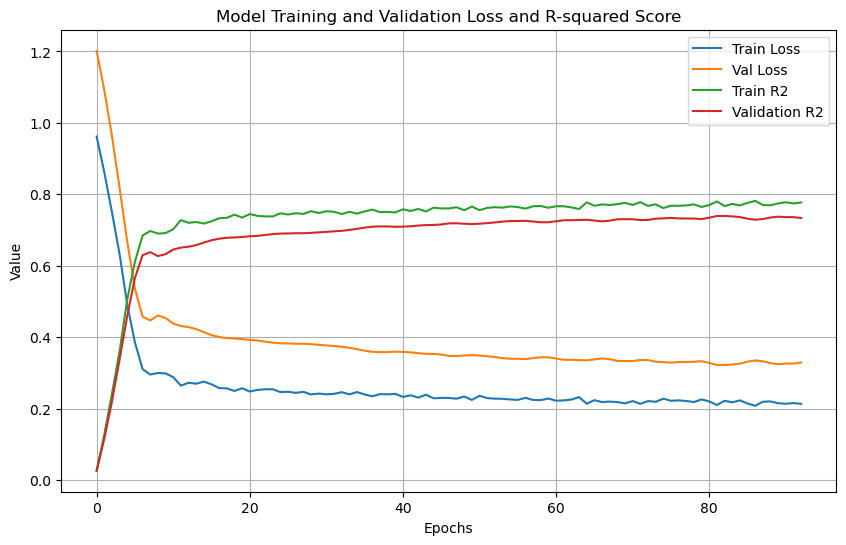

In [1733]:
from keras.optimizers import Adam

# initialize model
# model = Sequential()
# model.add(LSTM(50, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
# model.add(Dropout(0.2))
# model.add(Dense(1))

model = Sequential()
model.add(LSTM(128, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]), return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(128))
model.add(Dropout(0.3))
model.add(Dense(1))

def r_squared(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# Compile the model
optimizer = Adam(lr=0.001)
model.compile(optimizer=optimizer, 
              loss='mse',
              metrics=[r_squared])

model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# fit model
history = model.fit(X_train_scaled, y_train_scaled,
          epochs = 100,
          batch_size = 64,
          verbose = 0,
          callbacks=[early_stopping],
          shuffle = False,
          validation_split = 0.02)

# Obtain the MSE and R-squared from the last epoch
last_epoch_mse = history.history['loss'][-1]
last_epoch_r_squared = history.history['r_squared'][-1]
last_epoch_mse_val = history.history['val_loss'][-1]
last_epoch_r_squared_val = history.history['val_r_squared'][-1]

# Print the MSE and R-squared
print("Train Mean Squared Error (MSE) from the last epoch:", last_epoch_mse)
print("Train R-squared from the last epoch:", last_epoch_r_squared)
print("Val Mean Squared Error (MSE) from the last epoch:", last_epoch_mse_val)
print("Val R-squared from the last epoch:", last_epoch_r_squared_val)

# plot loss and r2 score
plt.figure(figsize=(10, 6))

# Plot train loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')

# Plot train R-squared score
plt.plot(history.history['r_squared'], label='Train R2')
plt.plot(history.history['val_r_squared'], label='Validation R2')

plt.title('Model Training and Validation Loss and R-squared Score')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [1734]:
# Evaluate the model
loss = model.evaluate(X_test_scaled, y_test_scaled)
print("MSE and R_squared:", loss)

2/2 [==============================] - 0s 16ms/step - loss: 0.1918 - r_squared: 0.5072
MSE and R_squared: [0.1917625218629837, 0.5071744918823242]


In [1735]:
train_predict = model.predict(X_train_scaled)
test_predict = model.predict(X_test_scaled)
print('train_predict:', train_predict.shape)
print('test_predict:', test_predict.shape)

2/2 [==============================] - 0s 7ms/step
train_predict: (251, 1)
test_predict: (35, 1)


In [1736]:
# invert predictions
train_predict = scaler_2.inverse_transform(train_predict)
print('train_predict:', train_predict.shape)

# invert y_train
y_train_scaled_inversed = scaler_2.inverse_transform(y_train_scaled)
print('y_train_scaled_inversed:', y_train_scaled_inversed.shape)

print('Train Mean Absolute Error:', mean_absolute_error(y_train, train_predict))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(y_train, train_predict)))

# plot the actual and predicted values for test data
trace1 = go.Scatter(x=np.arange(len(y_train)), y=y_train.flatten(), mode='lines', name='Actual Train')
trace2 = go.Scatter(x=np.arange(len(train_predict)), y=train_predict.flatten(), mode='lines', name='Predicted Train')

# Create layout
layout = go.Layout(
    title='British Columbia: LSTM Prediction on Mean Max Temp (°C)',
    xaxis=dict(title='Time step'),
    yaxis=dict(title='Mean Max Temp Values'),
    legend=dict(x=0, y=1.18)
)

# Create figure
fig = go.Figure(data=[trace1, trace2], layout=layout)

# Show plot
fig.show()

train_predict: (251, 1)
y_train_scaled_inversed: (251, 1)
Train Mean Absolute Error: 2.625849427487018
Train Root Mean Squared Error: 3.2065817426584173


In [1737]:
# invert predictions
test_predict = scaler_4.inverse_transform(test_predict)
print('test_predict:', test_predict.shape)

# invert y_test
y_test_scaled_inversed = scaler_4.inverse_transform(y_test_scaled)
print('y_test_scaled_inversed:', y_test_scaled_inversed.shape)

print('Test Mean Absolute Error:', mean_absolute_error(y_test, test_predict))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(y_test, test_predict)))

# plot the actual and predicted values for test data
trace1 = go.Scatter(x=np.arange(len(y_test)), y=y_test.flatten(), mode='lines', name='Actual Test')
trace2 = go.Scatter(x=np.arange(len(test_predict)), y=test_predict.flatten(), mode='lines', name='Predicted Test')

# Create layout
layout = go.Layout(
    title='British Columbia: LSTM Prediction on Mean Max Temp (°C)',
    xaxis=dict(title='Time step'),
    yaxis=dict(title='Mean Max Temp Values'),
    legend=dict(x=0, y=1.18)
)

# Create figure
fig = go.Figure(data=[trace1, trace2], layout=layout)

# Show plot
fig.show()

test_predict: (35, 1)
y_test_scaled_inversed: (35, 1)
Test Mean Absolute Error: 2.771972003448411
Test Root Mean Squared Error: 3.353116808707723


(2.4) Ontario

In [1738]:
resampled_ON = df[df['provincename'] == 'Ontario']

# RESAMPLING THE DATASET TO MONTHLY #

# split data into numeric and string
num_cols = resampled_ON.select_dtypes(include = ['number'])

# resample numeric data
resampled = num_cols.resample("M").mean()

resampled = resampled[columns]
resampled.head()

,Mean Max Temp (°C),Mean Min Temp (°C),Mean Temp (°C),Extr Max Temp (°C),Extr Min Temp (°C),Total Rain (mm),Total Snow (cm),Total Precip (mm),Snow Grnd Last Day (cm),Dir of Max Gust (10s deg),Spd of Max Gust (km/h)
Date/Time,,,,,,,,,,,
1998-01-31,-1.335346,-8.817714,-5.073900,8.603917,-21.208080,51.952941,32.298039,90.741176,12.921569,0.450980,1.098039
1998-02-28,2.038014,-6.539054,-2.244561,8.939422,-17.776302,25.582353,4.156863,31.288235,4.627451,0.607843,1.019608
1998-03-31,4.565397,-4.241625,0.163845,21.541639,-17.859510,49.825490,25.756863,77.333333,0.843137,0.078431,1.156863
1998-04-30,13.340110,1.406302,7.379227,21.728006,-4.285085,39.958824,0.517647,42.747059,0.000000,0.411765,1.019608
1998-05-31,21.705825,9.513872,15.624558,29.795932,2.421586,42.966667,0.031373,47.249020,0.000000,0.470588,1.352941


array([<Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>], dtype=object)

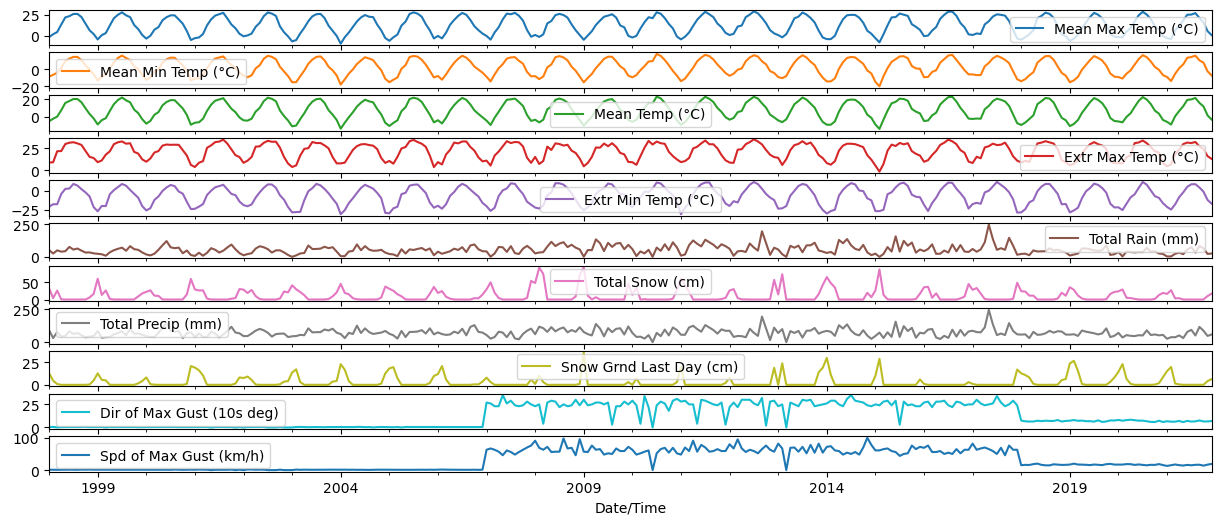

In [1739]:
resampled[['Mean Max Temp (°C)',
    'Mean Min Temp (°C)',
    'Mean Temp (°C)',
    'Extr Max Temp (°C)',
    'Extr Min Temp (°C)',
    'Total Rain (mm)',
    'Total Snow (cm)',
    'Total Precip (mm)',
    'Snow Grnd Last Day (cm)',
    'Dir of Max Gust (10s deg)',
    'Spd of Max Gust (km/h)']].plot(subplots = True)

In [1740]:
# split into train and test
train_end_date = '2018-12-31'

train_data = resampled[resampled.index <= train_end_date]
test_data = resampled[resampled.index > train_end_date]

print(f'Train data:')
print(train_data.index.min())
print(train_data.index.max())
print(train_data.shape)
print(f'Test data:')
print(test_data.index.min())
print(test_data.index.max())
print(test_data.shape)

Train data:
1998-01-31 00:00:00
2018-12-31 00:00:00
(252, 11)
Test data:
2019-01-31 00:00:00
2021-12-31 00:00:00
(36, 11)


In [1741]:
train_data_array = train_data.values
print(train_data_array[0])
print(train_data_array.shape)

test_data_array = test_data.values
print(test_data_array[0])
print(test_data_array.shape)


[ -1.335346   -8.8177137  -5.0739      8.6039171 -21.2080801  51.9529412
  32.2980392  90.7411765  12.9215686   0.4509804   1.0980392]
(252, 11)
[ -5.8099535 -15.2266609 -10.604187    5.5515707 -28.5769033  10.7
  35.25       57.4672414  23.7931034   7.3448276  17.1034483]
(36, 11)


In [1742]:
def split_to_train_test(dataset,n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
            dataX.append(dataset[i - n_past:i, 1:dataset.shape[1]])
            dataY.append(dataset[i- n_past,0])
    return np.array(dataX),np.array(dataY)    

In [1743]:
time_steps = 1

# TRAIN
X_train, y_train = split_to_train_test(train_data_array, time_steps)
print('Before reshape:')
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)

X_train = X_train.reshape(-1, X_train.shape[-1])
print('After reshape:')
print('X_train:', X_train.shape)

y_train = y_train.reshape((-1, 1))
print('y_train:', y_train.shape)

# TEST
X_test, y_test = split_to_train_test(test_data_array, time_steps)
print('Before reshape:')
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)

X_test = X_test.reshape(-1, X_train.shape[-1])
print('After reshape:')
print('X_test:', X_test.shape)

y_test = y_test.reshape((-1, 1))
print('y_test:', y_test.shape)

Before reshape:
X_train: (251, 1, 10)
y_train: (251,)
After reshape:
X_train: (251, 10)
y_train: (251, 1)
Before reshape:
X_test: (35, 1, 10)
y_test: (35,)
After reshape:
X_test: (35, 10)
y_test: (35, 1)


In [1744]:
scaler_1 = StandardScaler()
np.set_printoptions(precision=7)
X_train_scaled = scaler_1.fit_transform(X_train)
print('X_train_scaled:', X_train_scaled[0])
print('X_train_scaled:', X_train_scaled.shape)

scaler_2 = StandardScaler()
y_train_scaled = scaler_2.fit_transform(y_train)
print('y_train_scaled:', y_train_scaled[0:5])
print('y_train_scaled:', y_train_scaled.shape)

scaler_3 = StandardScaler()
X_test_scaled = scaler_3.fit_transform(X_test)
print('X_test_scaled:', X_test_scaled[0])
print('X_test_scaled:', X_test_scaled.shape)

scaler_4 = StandardScaler()
y_test_scaled = scaler_4.fit_transform(y_test)
print('y_test_scaled:', y_test_scaled[0:5])
print('y_test_scaled:', y_test_scaled.shape)

X_train_scaled: [-1.1692675 -1.255048  -1.4131664 -1.2104015 -0.1511058  1.1401111
  0.5530732  1.6674448 -1.0146913 -1.0405387]
X_train_scaled: (251, 10)
y_train_scaled: [[-1.3306734]
 [-1.0078312]
 [-0.7659518]
 [ 0.0738187]
 [ 0.8744465]]
y_train_scaled: (251, 1)
X_test_scaled: [-1.7824761 -1.7333155 -1.5726981 -1.7539917 -1.2725134  2.6237543
 -0.159955   2.350585   0.5191867  0.3714311]
X_test_scaled: (35, 10)
y_test_scaled: [[-1.6691196]
 [-1.4237365]
 [-0.9902666]
 [-0.2499402]
 [ 0.3625321]]
y_test_scaled: (35, 1)


In [1745]:
X_train_scaled = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
X_test_scaled = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])
print('X_train:', X_train.shape)
print('X_test:', X_test.shape)

X_train: (251, 10)
X_test: (35, 10)


Model: "sequential_174"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_234 (LSTM)             (None, 1, 128)            71168     
                                                                 
 dropout_120 (Dropout)       (None, 1, 128)            0         
                                                                 
 lstm_235 (LSTM)             (None, 128)               131584    
                                                                 
 dropout_121 (Dropout)       (None, 128)               0         
                                                                 
 dense_174 (Dense)           (None, 1)                 129       
                                                                 
Total params: 202881 (792.50 KB)
Trainable params: 202881 (792.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Train Mean S

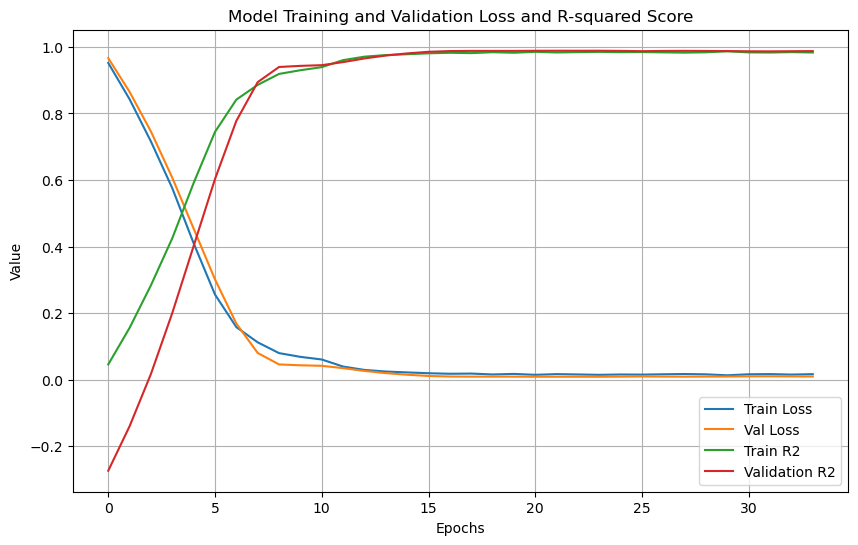

In [1746]:
from keras.optimizers import Adam

# initialize model
# model = Sequential()
# model.add(LSTM(50, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
# model.add(Dropout(0.2))
# model.add(Dense(1))

model = Sequential()
model.add(LSTM(128, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]), return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(128))
model.add(Dropout(0.3))
model.add(Dense(1))

def r_squared(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# Compile the model
optimizer = Adam(lr=0.001)
model.compile(optimizer=optimizer, 
              loss='mse',
              metrics=[r_squared])

model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# fit model
history = model.fit(X_train_scaled, y_train_scaled,
          epochs = 100,
          batch_size = 64,
          verbose = 0,
          callbacks=[early_stopping],
          shuffle = False,
          validation_split = 0.02)

# Obtain the MSE and R-squared from the last epoch
last_epoch_mse = history.history['loss'][-1]
last_epoch_r_squared = history.history['r_squared'][-1]
last_epoch_mse_val = history.history['val_loss'][-1]
last_epoch_r_squared_val = history.history['val_r_squared'][-1]

# Print the MSE and R-squared
print("Train Mean Squared Error (MSE) from the last epoch:", last_epoch_mse)
print("Train R-squared from the last epoch:", last_epoch_r_squared)
print("Val Mean Squared Error (MSE) from the last epoch:", last_epoch_mse_val)
print("Val R-squared from the last epoch:", last_epoch_r_squared_val)

# plot loss and r2 score
plt.figure(figsize=(10, 6))

# Plot train loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')

# Plot train R-squared score
plt.plot(history.history['r_squared'], label='Train R2')
plt.plot(history.history['val_r_squared'], label='Validation R2')

plt.title('Model Training and Validation Loss and R-squared Score')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [1747]:
# Evaluate the model
loss = model.evaluate(X_test_scaled, y_test_scaled)
print("MSE and R_squared:", loss)

2/2 [==============================] - 0s 0s/step - loss: 0.0040 - r_squared: 0.9881
MSE and R_squared: [0.003961341921240091, 0.9881126880645752]


In [1748]:
train_predict = model.predict(X_train_scaled)
test_predict = model.predict(X_test_scaled)
print('train_predict:', train_predict.shape)
print('test_predict:', test_predict.shape)

2/2 [==============================] - 0s 16ms/step
train_predict: (251, 1)
test_predict: (35, 1)


In [1749]:
# invert predictions
train_predict = scaler_2.inverse_transform(train_predict)
print('train_predict:', train_predict.shape)

# invert y_train
y_train_scaled_inversed = scaler_2.inverse_transform(y_train_scaled)
print('y_train_scaled_inversed:', y_train_scaled_inversed.shape)

print('Train Mean Absolute Error:', mean_absolute_error(y_train, train_predict))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(y_train, train_predict)))

# plot the actual and predicted values for test data
trace1 = go.Scatter(x=np.arange(len(y_train)), y=y_train.flatten(), mode='lines', name='Actual Train')
trace2 = go.Scatter(x=np.arange(len(train_predict)), y=train_predict.flatten(), mode='lines', name='Predicted Train')

# Create layout
layout = go.Layout(
    title='Ontario: LSTM Prediction on Mean Max Temp (°C)',
    xaxis=dict(title='Time step'),
    yaxis=dict(title='Mean Max Temp Values'),
    legend=dict(x=0, y=1.18)
)

# Create figure
fig = go.Figure(data=[trace1, trace2], layout=layout)

# Show plot
fig.show()

train_predict: (251, 1)
y_train_scaled_inversed: (251, 1)
Train Mean Absolute Error: 0.6338889733359767
Train Root Mean Squared Error: 0.8507734244785261


In [1750]:
# invert predictions
test_predict = scaler_4.inverse_transform(test_predict)
print('test_predict:', test_predict.shape)

# invert y_test
y_test_scaled_inversed = scaler_4.inverse_transform(y_test_scaled)
print('y_test_scaled_inversed:', y_test_scaled_inversed.shape)

print('Test Mean Absolute Error:', mean_absolute_error(y_test, test_predict))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(y_test, test_predict)))

# plot the actual and predicted values for test data
trace1 = go.Scatter(x=np.arange(len(y_test)), y=y_test.flatten(), mode='lines', name='Actual Test')
trace2 = go.Scatter(x=np.arange(len(test_predict)), y=test_predict.flatten(), mode='lines', name='Predicted Test')

# Create layout
layout = go.Layout(
    title='Ontario: LSTM Prediction on Mean Max Temp (°C)',
    xaxis=dict(title='Time step'),
    yaxis=dict(title='Mean Max Temp Values'),
    legend=dict(x=0, y=1.18)
)

# Create figure
fig = go.Figure(data=[trace1, trace2], layout=layout)

# Show plot
fig.show()

test_predict: (35, 1)
y_test_scaled_inversed: (35, 1)
Test Mean Absolute Error: 0.5009120437498454
Test Root Mean Squared Error: 0.6716597548884576


(2.5) Quebec

In [1751]:
resampled_QC = df[df['provincename'] == 'Quebec']

# RESAMPLING THE DATASET TO MONTHLY #

# split data into numeric and string
num_cols = resampled_QC.select_dtypes(include = ['number'])

# resample numeric data
resampled = num_cols.resample("M").mean()

resampled = resampled[columns]
resampled.head()

,Mean Max Temp (°C),Mean Min Temp (°C),Mean Temp (°C),Extr Max Temp (°C),Extr Min Temp (°C),Total Rain (mm),Total Snow (cm),Total Precip (mm),Snow Grnd Last Day (cm),Dir of Max Gust (10s deg),Spd of Max Gust (km/h)
Date/Time,,,,,,,,,,,
1998-01-31,-4.552563,-13.994682,-9.287824,5.741158,-29.829489,25.681176,43.316471,69.741176,35.976471,0.364706,0.847059
1998-02-28,-0.896600,-11.473360,-6.188613,7.167492,-25.858277,14.797647,16.928235,32.250588,31.517647,0.329412,0.670588
1998-03-31,2.044358,-7.643261,-2.797791,15.422714,-22.235325,45.856471,28.203529,75.307059,7.600000,0.341176,0.694118
1998-04-30,11.654923,-0.400211,5.643657,22.055794,-6.318341,38.970588,4.340000,43.837647,0.505882,0.317647,0.658824
1998-05-31,20.997578,7.887234,14.470646,28.402177,-0.216450,57.038824,0.000000,57.442353,0.000000,0.105882,0.717647


array([<Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>], dtype=object)

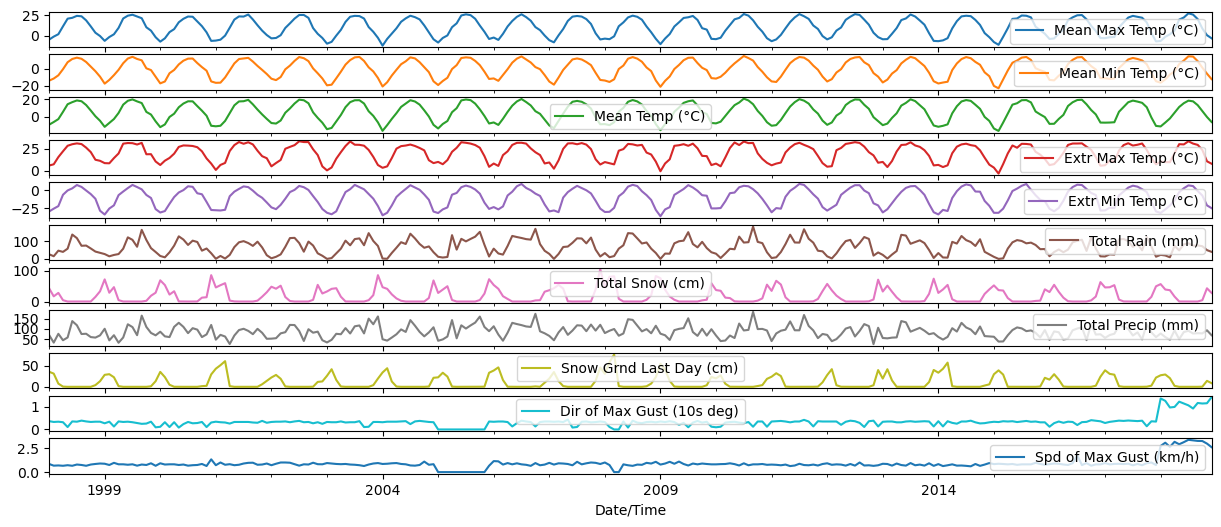

In [1752]:
resampled[['Mean Max Temp (°C)',
    'Mean Min Temp (°C)',
    'Mean Temp (°C)',
    'Extr Max Temp (°C)',
    'Extr Min Temp (°C)',
    'Total Rain (mm)',
    'Total Snow (cm)',
    'Total Precip (mm)',
    'Snow Grnd Last Day (cm)',
    'Dir of Max Gust (10s deg)',
    'Spd of Max Gust (km/h)']].plot(subplots = True)

In [1753]:
# split into train and test
train_end_date = '2018-12-31'

train_data = resampled[resampled.index <= train_end_date]
test_data = resampled[resampled.index > train_end_date]

print(f'Train data:')
print(train_data.index.min())
print(train_data.index.max())
print(train_data.shape)
print(f'Test data:')
print(test_data.index.min())
print(test_data.index.max())
print(test_data.shape)

Train data:
1998-01-31 00:00:00
2018-12-31 00:00:00
(252, 11)
Test data:
NaT
NaT
(0, 11)


In [1754]:
# train_data_array = train_data.values
# print(train_data_array[0])
# print(train_data_array.shape)

# test_data_array = test_data.values
# print(test_data_array[0])
# print(test_data_array.shape)


In [1755]:
# def split_to_train_test(dataset,n_past):
#     dataX = []
#     dataY = []
#     for i in range(n_past, len(dataset)):
#             dataX.append(dataset[i - n_past:i, 1:dataset.shape[1]])
#             dataY.append(dataset[i- n_past,0])
#     return np.array(dataX),np.array(dataY)    

In [1756]:
# time_steps = 1

# # TRAIN
# X_train, y_train = split_to_train_test(train_data_array, time_steps)
# print('Before reshape:')
# print('X_train:', X_train.shape)
# print('y_train:', y_train.shape)

# X_train = X_train.reshape(-1, X_train.shape[-1])
# print('After reshape:')
# print('X_train:', X_train.shape)

# y_train = y_train.reshape((-1, 1))
# print('y_train:', y_train.shape)

# # TEST
# X_test, y_test = split_to_train_test(test_data_array, time_steps)
# print('Before reshape:')
# print('X_test:', X_test.shape)
# print('y_test:', y_test.shape)

# X_test = X_test.reshape(-1, X_train.shape[-1])
# print('After reshape:')
# print('X_test:', X_test.shape)

# y_test = y_test.reshape((-1, 1))
# print('y_test:', y_test.shape)

In [1757]:
# scaler_1 = StandardScaler()
# np.set_printoptions(precision=7)
# X_train_scaled = scaler_1.fit_transform(X_train)
# print('X_train_scaled:', X_train_scaled[0])
# print('X_train_scaled:', X_train_scaled.shape)

# scaler_2 = StandardScaler()
# y_train_scaled = scaler_2.fit_transform(y_train)
# print('y_train_scaled:', y_train_scaled[0:5])
# print('y_train_scaled:', y_train_scaled.shape)

# scaler_3 = StandardScaler()
# X_test_scaled = scaler_3.fit_transform(X_test)
# print('X_test_scaled:', X_test_scaled[0])
# print('X_test_scaled:', X_test_scaled.shape)

# scaler_4 = StandardScaler()
# y_test_scaled = scaler_4.fit_transform(y_test)
# print('y_test_scaled:', y_test_scaled[0:5])
# print('y_test_scaled:', y_test_scaled.shape)

In [1758]:
# X_train_scaled = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
# X_test_scaled = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])
# print('X_train:', X_train.shape)
# print('X_test:', X_test.shape)

In [1759]:
# from keras.optimizers import Adam

# # initialize model
# # model = Sequential()
# # model.add(LSTM(50, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
# # model.add(Dropout(0.2))
# # model.add(Dense(1))

# model = Sequential()
# model.add(LSTM(128, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]), return_sequences=True))
# model.add(Dropout(0.3))
# model.add(LSTM(128))
# model.add(Dropout(0.3))
# model.add(Dense(1))

# def r_squared(y_true, y_pred):
#     SS_res =  K.sum(K.square(y_true - y_pred)) 
#     SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
#     return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# # Compile the model
# optimizer = Adam(lr=0.001)
# model.compile(optimizer=optimizer, 
#               loss='mse',
#               metrics=[r_squared])

# model.summary()

# early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# # fit model
# history = model.fit(X_train_scaled, y_train_scaled,
#           epochs = 100,
#           batch_size = 64,
#           verbose = 0,
#           callbacks=[early_stopping],
#           shuffle = False,
#           validation_split = 0.02)

# # Obtain the MSE and R-squared from the last epoch
# last_epoch_mse = history.history['loss'][-1]
# last_epoch_r_squared = history.history['r_squared'][-1]
# last_epoch_mse_val = history.history['val_loss'][-1]
# last_epoch_r_squared_val = history.history['val_r_squared'][-1]

# # Print the MSE and R-squared
# print("Train Mean Squared Error (MSE) from the last epoch:", last_epoch_mse)
# print("Train R-squared from the last epoch:", last_epoch_r_squared)
# print("Val Mean Squared Error (MSE) from the last epoch:", last_epoch_mse_val)
# print("Val R-squared from the last epoch:", last_epoch_r_squared_val)

# # plot loss and r2 score
# plt.figure(figsize=(10, 6))

# # Plot train loss
# plt.plot(history.history['loss'], label='Train Loss')
# plt.plot(history.history['val_loss'], label='Val Loss')

# # Plot train R-squared score
# plt.plot(history.history['r_squared'], label='Train R2')
# plt.plot(history.history['val_r_squared'], label='Validation R2')

# plt.title('Model Training and Validation Loss and R-squared Score')
# plt.xlabel('Epochs')
# plt.ylabel('Value')
# plt.legend()
# plt.grid(True)
# plt.show()

In [1760]:
# # Evaluate the model
# loss = model.evaluate(X_test_scaled, y_test_scaled)
# print("MSE and R_squared:", loss)

In [1761]:
# train_predict = model.predict(X_train_scaled)
# test_predict = model.predict(X_test_scaled)
# print('train_predict:', train_predict.shape)
# print('test_predict:', test_predict.shape)

In [1762]:
# # invert predictions
# train_predict = scaler_2.inverse_transform(train_predict)
# print('train_predict:', train_predict.shape)

# # invert y_train
# y_train_scaled_inversed = scaler_2.inverse_transform(y_train_scaled)
# print('y_train_scaled_inversed:', y_train_scaled_inversed.shape)

# print('Train Mean Absolute Error:', mean_absolute_error(y_train, train_predict))
# print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(y_train, train_predict)))

# # plot the actual and predicted values for test data
# trace1 = go.Scatter(x=np.arange(len(y_train)), y=y_train.flatten(), mode='lines', name='Actual Train')
# trace2 = go.Scatter(x=np.arange(len(train_predict)), y=train_predict.flatten(), mode='lines', name='Predicted Train')

# # Create layout
# layout = go.Layout(
#     title='Quebec: LSTM Prediction on Mean Max Temp (°C)',
#     xaxis=dict(title='Time step'),
#     yaxis=dict(title='Mean Max Temp Values'),
#     legend=dict(x=0, y=1.18)
# )

# # Create figure
# fig = go.Figure(data=[trace1, trace2], layout=layout)

# # Show plot
# fig.show()

In [1763]:
# # invert predictions
# test_predict = scaler_4.inverse_transform(test_predict)
# print('test_predict:', test_predict.shape)

# # invert y_test
# y_test_scaled_inversed = scaler_4.inverse_transform(y_test_scaled)
# print('y_test_scaled_inversed:', y_test_scaled_inversed.shape)

# print('Test Mean Absolute Error:', mean_absolute_error(y_test, test_predict))
# print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(y_test, test_predict)))

# # plot the actual and predicted values for test data
# trace1 = go.Scatter(x=np.arange(len(y_test)), y=y_test.flatten(), mode='lines', name='Actual Test')
# trace2 = go.Scatter(x=np.arange(len(test_predict)), y=test_predict.flatten(), mode='lines', name='Predicted Test')

# # Create layout
# layout = go.Layout(
#     title='Quebec: LSTM Prediction on Mean Max Temp (°C)',
#     xaxis=dict(title='Time step'),
#     yaxis=dict(title='Mean Max Temp Values'),
#     legend=dict(x=0, y=1.18)
# )

# # Create figure
# fig = go.Figure(data=[trace1, trace2], layout=layout)

# # Show plot
# fig.show()

(2.6) Saskatchewan

In [1764]:
resampled_SK = df[df['provincename'] == 'Saskatchewan']

# RESAMPLING THE DATASET TO MONTHLY #

# split data into numeric and string
num_cols = resampled_SK.select_dtypes(include = ['number'])

# resample numeric data
resampled = num_cols.resample("M").mean()

resampled = resampled[columns]
resampled.head()

,Mean Max Temp (°C),Mean Min Temp (°C),Mean Temp (°C),Extr Max Temp (°C),Extr Min Temp (°C),Total Rain (mm),Total Snow (cm),Total Precip (mm),Snow Grnd Last Day (cm),Dir of Max Gust (10s deg),Spd of Max Gust (km/h)
Date/Time,,,,,,,,,,,
1998-01-31,-12.126696,-21.643371,-16.911877,1.957775,-36.132356,0.071111,15.202222,17.271111,7.977778,0.511111,1.244444
1998-02-28,-1.101262,-9.118113,-5.137857,6.325029,-21.979885,1.924444,7.760000,12.533333,8.222222,0.733333,1.111111
1998-03-31,-0.781830,-12.051365,-6.422710,13.616929,-28.278167,0.448889,6.444444,10.053333,3.244444,0.155556,1.244444
1998-04-30,13.740122,-0.558231,6.620447,25.554963,-8.135638,12.095652,0.854348,12.989130,0.000000,0.673913,1.326087
1998-05-31,19.580392,4.087789,11.856558,27.889747,-4.563031,27.563043,0.145652,27.819565,0.000000,0.673913,1.282609


array([<Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>], dtype=object)

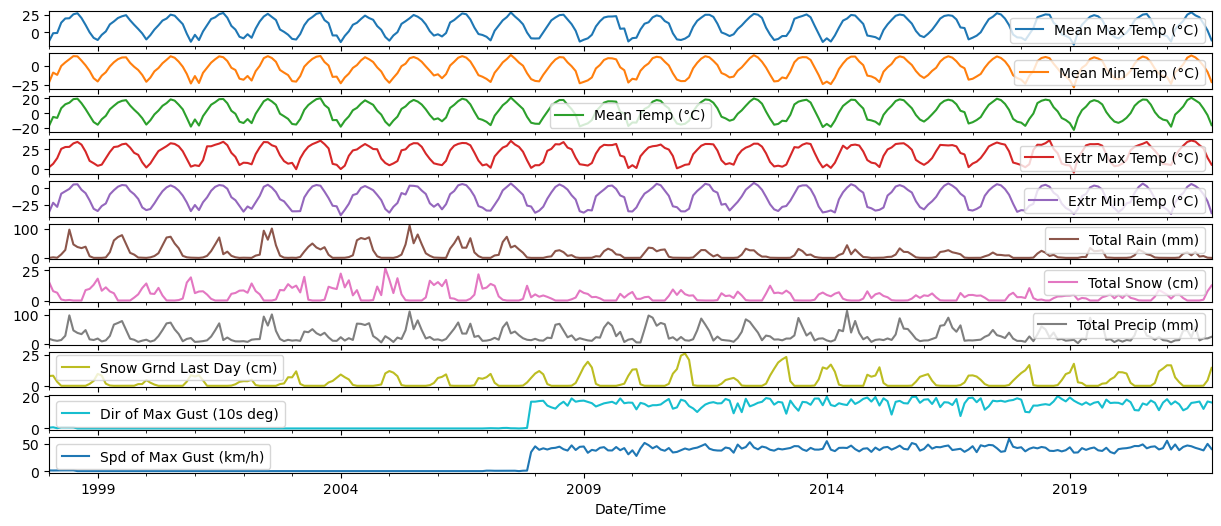

In [1765]:
resampled[['Mean Max Temp (°C)',
    'Mean Min Temp (°C)',
    'Mean Temp (°C)',
    'Extr Max Temp (°C)',
    'Extr Min Temp (°C)',
    'Total Rain (mm)',
    'Total Snow (cm)',
    'Total Precip (mm)',
    'Snow Grnd Last Day (cm)',
    'Dir of Max Gust (10s deg)',
    'Spd of Max Gust (km/h)']].plot(subplots = True)

In [1766]:
# split into train and test
train_end_date = '2018-12-31'

train_data = resampled[resampled.index <= train_end_date]
test_data = resampled[resampled.index > train_end_date]

print(f'Train data:')
print(train_data.index.min())
print(train_data.index.max())
print(train_data.shape)
print(f'Test data:')
print(test_data.index.min())
print(test_data.index.max())
print(test_data.shape)

Train data:
1998-01-31 00:00:00
2018-12-31 00:00:00
(252, 11)
Test data:
2019-01-31 00:00:00
2021-12-31 00:00:00
(36, 11)


In [1767]:
train_data_array = train_data.values
print(train_data_array[0])
print(train_data_array.shape)

test_data_array = test_data.values
print(test_data_array[0])
print(test_data_array.shape)


[-12.1266961 -21.6433711 -16.9118767   1.9577753 -36.1323565   0.0711111
  15.2022222  17.2711111   7.9777778   0.5111111   1.2444444]
(252, 11)
[ -7.9390236 -18.9830053 -13.4655891   4.2858813 -33.2114719   0.072
   4.064      11.956      10.86       19.28       43.78     ]
(36, 11)


In [1768]:
def split_to_train_test(dataset,n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
            dataX.append(dataset[i - n_past:i, 1:dataset.shape[1]])
            dataY.append(dataset[i - n_past,0])
    return np.array(dataX),np.array(dataY)    

In [1769]:
time_steps = 1

# TRAIN
X_train, y_train = split_to_train_test(train_data_array, time_steps)
print('Before reshape:')
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)

X_train = X_train.reshape(-1, X_train.shape[-1])
print('After reshape:')
print('X_train:', X_train.shape)

y_train = y_train.reshape((-1, 1))
print('y_train:', y_train.shape)

# TEST
X_test, y_test = split_to_train_test(test_data_array, time_steps)
print('Before reshape:')
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)

X_test = X_test.reshape(-1, X_train.shape[-1])
print('After reshape:')
print('X_test:', X_test.shape)

y_test = y_test.reshape((-1, 1))
print('y_test:', y_test.shape)

Before reshape:
X_train: (251, 1, 10)
y_train: (251,)
After reshape:
X_train: (251, 10)
y_train: (251, 1)
Before reshape:
X_test: (35, 1, 10)
y_test: (35,)
After reshape:
X_test: (35, 10)
y_test: (35, 1)


In [1770]:
scaler_1 = StandardScaler()
np.set_printoptions(precision=7)
X_train_scaled = scaler_1.fit_transform(X_train)
print('X_train_scaled:', X_train_scaled[0])
print('X_train_scaled:', X_train_scaled.shape)

scaler_2 = StandardScaler()
y_train_scaled = scaler_2.fit_transform(y_train)
print('y_train_scaled:', y_train_scaled[0:5])
print('y_train_scaled:', y_train_scaled.shape)

scaler_3 = StandardScaler()
X_test_scaled = scaler_3.fit_transform(X_test)
print('X_test_scaled:', X_test_scaled[0])
print('X_test_scaled:', X_test_scaled.shape)

scaler_4 = StandardScaler()
y_test_scaled = scaler_4.fit_transform(y_test)
print('y_test_scaled:', y_test_scaled[0:5])
print('y_test_scaled:', y_test_scaled.shape)

X_train_scaled: [-1.6723784 -1.6803043 -1.5816938 -1.5691562 -0.7396374  2.1224493
 -0.5814022  0.8620398 -0.9689718 -0.9868197]
X_train_scaled: (251, 10)
y_train_scaled: [[-1.6813983]
 [-0.7895535]
 [-0.7637147]
 [ 0.4109627]
 [ 0.8833807]]
y_train_scaled: (251, 1)
X_test_scaled: [-1.3885413 -1.369196  -1.4150784 -1.310634  -0.7790129  0.6245494
 -0.6676608  1.1073046  1.878988   0.3130679]
X_test_scaled: (35, 10)
y_test_scaled: [[-1.3482153]
 [-2.0774316]
 [-0.7155154]
 [ 0.1337115]
 [ 0.5965717]]
y_test_scaled: (35, 1)


In [1771]:
X_train_scaled = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
X_test_scaled = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])
print('X_train:', X_train.shape)
print('X_test:', X_test.shape)

X_train: (251, 10)
X_test: (35, 10)


Model: "sequential_175"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_236 (LSTM)             (None, 1, 128)            71168     
                                                                 
 dropout_122 (Dropout)       (None, 1, 128)            0         
                                                                 
 lstm_237 (LSTM)             (None, 128)               131584    
                                                                 
 dropout_123 (Dropout)       (None, 128)               0         
                                                                 
 dense_175 (Dense)           (None, 1)                 129       
                                                                 
Total params: 202881 (792.50 KB)
Trainable params: 202881 (792.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Train Mean S

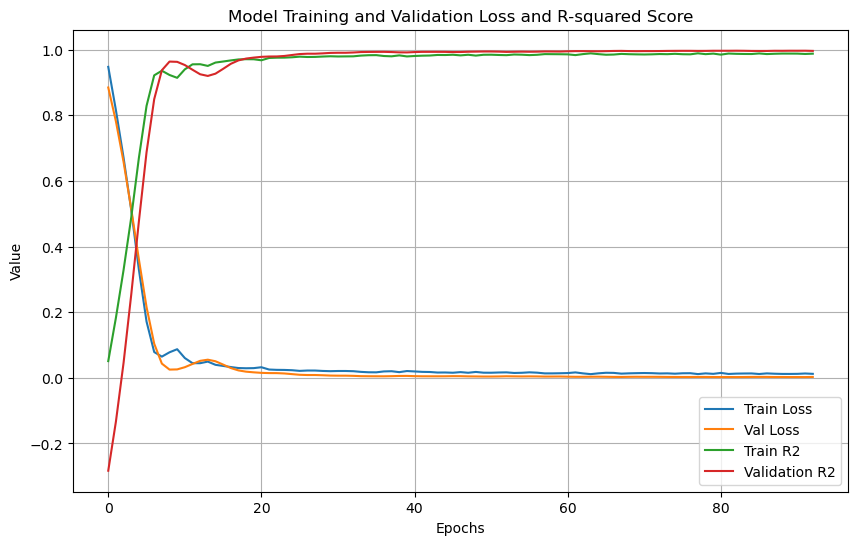

In [1772]:
from keras.optimizers import Adam

# initialize model
# model = Sequential()
# model.add(LSTM(50, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
# model.add(Dropout(0.2))
# model.add(Dense(1))

model = Sequential()
model.add(LSTM(128, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]), return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(128))
model.add(Dropout(0.3))
model.add(Dense(1))

def r_squared(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# Compile the model
optimizer = Adam(lr=0.001)
model.compile(optimizer=optimizer, 
              loss='mse',
              metrics=[r_squared])

model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# fit model
history = model.fit(X_train_scaled, y_train_scaled,
          epochs = 100,
          batch_size = 64,
          verbose = 0,
          callbacks=[early_stopping],
          shuffle = False,
          validation_split = 0.02)

# Obtain the MSE and R-squared from the last epoch
last_epoch_mse = history.history['loss'][-1]
last_epoch_r_squared = history.history['r_squared'][-1]
last_epoch_mse_val = history.history['val_loss'][-1]
last_epoch_r_squared_val = history.history['val_r_squared'][-1]

# Print the MSE and R-squared
print("Train Mean Squared Error (MSE) from the last epoch:", last_epoch_mse)
print("Train R-squared from the last epoch:", last_epoch_r_squared)
print("Val Mean Squared Error (MSE) from the last epoch:", last_epoch_mse_val)
print("Val R-squared from the last epoch:", last_epoch_r_squared_val)

# plot loss and r2 score
plt.figure(figsize=(10, 6))

# Plot train loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')

# Plot train R-squared score
plt.plot(history.history['r_squared'], label='Train R2')
plt.plot(history.history['val_r_squared'], label='Validation R2')

plt.title('Model Training and Validation Loss and R-squared Score')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [1773]:
# Evaluate the model
loss = model.evaluate(X_test_scaled, y_test_scaled)
print("MSE and R_squared:", loss)

2/2 [==============================] - 0s 5ms/step - loss: 0.0080 - r_squared: 0.9890
MSE and R_squared: [0.0080331489443779, 0.9890011548995972]


In [1774]:
train_predict = model.predict(X_train_scaled)
test_predict = model.predict(X_test_scaled)
print('train_predict:', train_predict.shape)
print('test_predict:', test_predict.shape)

2/2 [==============================] - 0s 8ms/step
train_predict: (251, 1)
test_predict: (35, 1)


In [1775]:
# invert predictions
train_predict = scaler_2.inverse_transform(train_predict)
print('train_predict:', train_predict.shape)

# invert y_train
y_train_scaled_inversed = scaler_2.inverse_transform(y_train_scaled)
print('y_train_scaled_inversed:', y_train_scaled_inversed.shape)

print('Train Mean Absolute Error:', mean_absolute_error(y_train, train_predict))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(y_train, train_predict)))

# plot the actual and predicted values for test data
trace1 = go.Scatter(x=np.arange(len(y_train)), y=y_train.flatten(), mode='lines', name='Actual Train')
trace2 = go.Scatter(x=np.arange(len(train_predict)), y=train_predict.flatten(), mode='lines', name='Predicted Train')

# Create layout
layout = go.Layout(
    title='Saskatchewan: LSTM Prediction on Mean Max Temp (°C)',
    xaxis=dict(title='Time step'),
    yaxis=dict(title='Mean Max Temp Values'),
    legend=dict(x=0, y=1.18)
)

# Create figure
fig = go.Figure(data=[trace1, trace2], layout=layout)

# Show plot
fig.show()

train_predict: (251, 1)
y_train_scaled_inversed: (251, 1)
Train Mean Absolute Error: 0.6765263111687628
Train Root Mean Squared Error: 0.8345847275948374


In [1776]:
# invert predictions
test_predict = scaler_4.inverse_transform(test_predict)
print('test_predict:', test_predict.shape)

# invert y_test
y_test_scaled_inversed = scaler_4.inverse_transform(y_test_scaled)
print('y_test_scaled_inversed:', y_test_scaled_inversed.shape)

print('Test Mean Absolute Error:', mean_absolute_error(y_test, test_predict))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(y_test, test_predict)))

# plot the actual and predicted values for test data
trace1 = go.Scatter(x=np.arange(len(y_test)), y=y_test.flatten(), mode='lines', name='Actual Test')
trace2 = go.Scatter(x=np.arange(len(test_predict)), y=test_predict.flatten(), mode='lines', name='Predicted Test')

# Create layout
layout = go.Layout(
    title='Saskatchewan: LSTM Prediction on Mean Max Temp (°C)',
    xaxis=dict(title='Time step'),
    yaxis=dict(title='Mean Max Temp Values'),
    legend=dict(x=0, y=1.18)
)

# Create figure
fig = go.Figure(data=[trace1, trace2], layout=layout)

# Show plot
fig.show()

test_predict: (35, 1)
y_test_scaled_inversed: (35, 1)
Test Mean Absolute Error: 0.9639969996359045
Test Root Mean Squared Error: 1.1317755902307551
